# Análisis Exploratorio Inicial: tabla fact orders
# Dataset: Brazilian E-Commerce Public Dataset by Olist
[https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce]

Yasmin Ohana - legajo: 65098

Julia Sexe - legajo: 65669

Alexis Florian Rehmann - legajo: 61251

En esta notebook se presenta únicamente el análisis de resultados y las conclusiones finales. Para un detalle exhaustivo de todos los pasos, exploraciones, decisiones de preprocesamiento y análisis intermedios que condujeron a estas decisiones, por favor consulte la notebook 'DETALLE'.

##Carga de librerías necesarias y gestión de warnings.

In [1]:
import os, json, pathlib
import zipfile, pathlib, re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import boxcox, zscore
from scipy.special import inv_boxcox
from scipy.stats import yeojohnson
from scipy.stats import chi2
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import statsmodels.api as sm
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import DBSCAN

In [2]:
# === Celda única para gestionar warnings / ruidos numéricos ===

from statsmodels.tools.sm_exceptions import (
    ConvergenceWarning, PerfectSeparationWarning,
    HessianInversionWarning, IterationLimitWarning
)

warnings.filterwarnings("once")

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

warnings.filterwarnings(
    "ignore",
    category=DeprecationWarning,
    module=r"jupyter_client\..*",
    message=r".*datetime\.utcnow\(\) is deprecated.*"
)

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=HessianInversionWarning)
warnings.filterwarnings("ignore", category=IterationLimitWarning)
warnings.filterwarnings("ignore", category=PerfectSeparationWarning)
warnings.filterwarnings("ignore", category=UserWarning, module=r"statsmodels\..*")

warnings.filterwarnings("ignore", category=RuntimeWarning, module=r"statsmodels\..*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=r".*overflow encountered in exp.*")
warnings.filterwarnings("ignore", category=RuntimeWarning, message=r".*divide by zero encountered.*")

np.seterr(over='ignore', divide='ignore', invalid='ignore', under='ignore')

warnings.filterwarnings("ignore",
    category=PendingDeprecationWarning,
    module=r"seaborn\..*")

##Ingesta de los datos desde Kaggle.
Aclaración: los archivos crudos están subidos en el repositorio de GitHub pero no realizamos la ingesta desde ahí ya que el archivo "Olist_geolocation_dataset.csv" era muy pesado y no permitía ser subido al repositorio.

In [3]:
!pip -q install kaggle

KAGGLE_USERNAME = "yasminohana1"
KAGGLE_KEY      = "4b30102e8deedd1447edf89efab04761"

os.environ["KAGGLE_USERNAME"] = KAGGLE_USERNAME
os.environ["KAGGLE_KEY"] = KAGGLE_KEY

path = pathlib.Path("~/.kaggle").expanduser()
path.mkdir(parents=True, exist_ok=True)
with open(path / "kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
def kaggle_slug_from_url(url_or_slug: str) -> str:
    m = re.search(r"kaggle\.com/datasets/([^/?#]+/[^/?#]+)", url_or_slug)
    return m.group(1) if m else url_or_slug.strip()

def kaggle_download(url_or_slug: str, dest="/content/data"):
    slug = kaggle_slug_from_url(url_or_slug)
    dest = pathlib.Path(dest)
    dest.mkdir(parents=True, exist_ok=True)
    print(f"Descargando: {slug} → {dest}")
    !kaggle datasets download -d {slug} -p {dest} -q
    # descomprimir todos los .zip que queden en dest
    for z in dest.glob("*.zip"):
        with zipfile.ZipFile(z) as zf:
            zf.extractall(dest)
        z.unlink()
    print("Listo. Archivos en:", dest)
    return dest

In [5]:
olist_dir = kaggle_download("https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce",
                            dest="/content/olist")
!ls -1 {olist_dir}

Descargando: olistbr/brazilian-ecommerce → /content/olist
Dataset URL: https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce
License(s): CC-BY-NC-SA-4.0
Listo. Archivos en: /content/olist
olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_order_items_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_orders_dataset.csv
olist_products_dataset.csv
olist_sellers_dataset.csv
product_category_name_translation.csv


In [6]:
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

DATA = Path("/content/olist")

date_cols_orders = [
    "order_purchase_timestamp","order_approved_at",
    "order_delivered_carrier_date","order_delivered_customer_date",
    "order_estimated_delivery_date"
]

orders   = pd.read_csv(DATA/"olist_orders_dataset.csv", parse_dates=date_cols_orders)
payments = pd.read_csv(DATA/"olist_order_payments_dataset.csv")
reviews  = pd.read_csv(DATA/"olist_order_reviews_dataset.csv",
                       parse_dates=["review_creation_date","review_answer_timestamp"])
customers= pd.read_csv(DATA/"olist_customers_dataset.csv")
geo      = pd.read_csv(DATA/"olist_geolocation_dataset.csv")

##Análisis exploratorio inicial de los datos.

En esta sección se realiza el análisis exploratorio sobre las tablas que influyen en la fact orders.

###Forma y tamaño del dataset. Análisis de valores únicos.

In [7]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26


In [8]:
print("geo – filas totales:", f"{len(geo):,}")
pref = geo['geolocation_zip_code_prefix']
print("prefijos únicos:", f"{pref.nunique():,}")
dup = geo.groupby('geolocation_zip_code_prefix').size()
print("% de prefijos con >1 fila:", round((dup > 1).mean()*100, 1), "%")

geo – filas totales: 1,000,163
prefijos únicos: 19,015
% de prefijos con >1 fila: 94.5 %


In [9]:
orders.head()
orders.info()
orders.describe()
for i in orders.columns:
  print(i, orders[i].isnull().sum())

# aca hay nulos, vamos a imputar más adelante

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
dtypes: datetime64[ns](5), object(3)
memory usage: 6.1+ MB
order_id 0
customer_id 0
order_status 0
order_purchase_timestamp 0
order_approved_at 160
order_delivered_carrier_date 1783
order_delivered_customer_date 2965
order

In [10]:
orders['order_status'].value_counts()

,count
order_status,
delivered,96478
shipped,1107
canceled,625
unavailable,609
invoiced,314
processing,301
created,5
approved,2


In [11]:
payments.info()
payments.describe()
for i in payments.columns:
  print(i, payments[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB
order_id 0
payment_sequential 0
payment_type 0
payment_installments 0
payment_value 0


In [12]:
payments['payment_installments'].value_counts()

,count
payment_installments,
1,52546
2,12413
3,10461
4,7098
10,5328
5,5239
8,4268
6,3920
7,1626


In [13]:
payments['payment_type'].value_counts()

,count
payment_type,
credit_card,76795
boleto,19784
voucher,5775
debit_card,1529
not_defined,3


In [14]:
payments['payment_value'].value_counts()

,count
payment_value,
50.00,324
20.00,274
100.00,255
77.57,250
35.00,165
...,...
19.18,1
713.65,1
366.73,1


In [15]:
payments['payment_sequential'].value_counts()

,count
payment_sequential,
1,99360
2,3039
3,581
4,278
5,170
6,118
7,82
8,54
9,43


In [16]:
reviews.info()
reviews.describe()
for i in reviews.columns:
  print(i, reviews[i].isnull().sum())

# tenemos valores nulos en los titulos y mensajes, pero como son textos decidimos no entrar en el mundo de procesamiento de lenguaje natural.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 5.3+ MB
review_id 0
order_id 0
review_score 0
review_comment_title 87656
review_comment_message 58247
review_creation_date 0
review_answer_timestamp 0


In [17]:
reviews['review_score'].value_counts()

,count
review_score,
5,57328
4,19142
1,11424
3,8179
2,3151


In [18]:
reviews['review_answer_timestamp'].nunique()

98248

In [19]:
reviews['review_answer_timestamp'].unique() ##todas fechas

<DatetimeArray>
['2018-01-18 21:46:59', '2018-03-11 03:05:13', '2018-02-18 14:36:24',
 '2017-04-21 22:02:06', '2018-03-02 10:26:53', '2018-04-16 00:39:37',
 '2017-07-18 19:30:34', '2018-08-14 21:36:06', '2017-05-18 12:05:37',
 '2018-05-23 16:45:47',
 ...
 '2018-05-26 21:24:06', '2018-05-20 21:51:06', '2018-05-10 14:37:03',
 '2017-12-14 11:09:36', '2018-04-30 01:18:57', '2018-07-14 17:18:30',
 '2017-12-11 20:06:42', '2018-03-23 09:10:43', '2018-07-02 12:59:13',
 '2017-07-03 21:01:49']
Length: 98248, dtype: datetime64[ns]

In [20]:
customers.info()
customers.describe()
for i in customers.columns:
  print(i, customers[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB
customer_id 0
customer_unique_id 0
customer_zip_code_prefix 0
customer_city 0
customer_state 0


In [21]:
customers['customer_unique_id'].value_counts()

,count
customer_unique_id,
8d50f5eadf50201ccdcedfb9e2ac8455,17
3e43e6105506432c953e165fb2acf44c,9
ca77025e7201e3b30c44b472ff346268,7
1b6c7548a2a1f9037c1fd3ddfed95f33,7
6469f99c1f9dfae7733b25662e7f1782,7
...,...
4f83c83b7ff5b544a8c75dcb8ad66e2e,1
3fe413dde400746c53c5d0d38b266ca2,1
289e1d1ce11a14bb169775d58ad2f1c2,1


In [22]:
customers.shape

(99441, 5)

In [23]:
customers['customer_id'].nunique()

99441

In [24]:
geo.info()
geo.describe()
for i in geo.columns:
  print(i, geo[i].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB
geolocation_zip_code_prefix 0
geolocation_lat 0
geolocation_lng 0
geolocation_city 0
geolocation_state 0


In [25]:
pays_per_order  = payments.groupby("order_id").size()
revs_per_order  = reviews.groupby("order_id").size()

print("Pagos por orden  → mediana:", int(pays_per_order.median()),  "| máx:", int(pays_per_order.max()))
print("Reviews por orden→ mediana:", int(revs_per_order.median()),   "| máx:", int(revs_per_order.max()))

Pagos por orden  → mediana: 1 | máx: 29
Reviews por orden→ mediana: 1 | máx: 3


In [26]:
orders_with_multiple_reviews = revs_per_order[revs_per_order > 1]

if len(orders_with_multiple_reviews) > 0:
    print(f"Hay {len(orders_with_multiple_reviews)} órdenes con más de una review.")
else:
    print("No hay órdenes con más de una review.")

Hay 547 órdenes con más de una review.


In [27]:
##sumo monto total, tomo la mayor cant de cuotas
def modo(s):
    m = s.mode(dropna=True)
    return m.iloc[0] if len(m) else np.nan

pay_agg = (payments
           .groupby("order_id", as_index=False)
           .agg(payment_value_total=("payment_value","sum"),
                payment_installments_max=("payment_installments","max"),
                payment_type_mode=("payment_type", modo)))

In [28]:
##con las reviews me quedo con la mas reciente

reviews_sorted = reviews.sort_values(["order_id","review_creation_date"])
rev_agg = (reviews_sorted
           .groupby("order_id", as_index=False)
           .agg(review_score=("review_score","last"),
                review_comment_title=("review_comment_title","last"),
                review_comment_message=("review_comment_message","last"),
                review_creation_date=("review_creation_date","last"),
                review_answer_timestamp=("review_answer_timestamp","last")))

In [29]:
geo_agg = (geo.groupby("geolocation_zip_code_prefix", as_index=False)
             .agg(geolocation_lat=("geolocation_lat","mean"),
                  geolocation_lng=("geolocation_lng","mean"),
                  geolocation_city=("geolocation_city", modo),
                  geolocation_state=("geolocation_state", modo)))

In [30]:
##clientes + geo
cust_geo = customers.merge(
    geo_agg.rename(columns={
        "geolocation_zip_code_prefix":"customer_zip_code_prefix",
        "geolocation_lat":"customer_lat","geolocation_lng":"customer_lng",
        "geolocation_city":"customer_geo_city","geolocation_state":"customer_geo_state"
    }),
    on="customer_zip_code_prefix", how="left"
)

In [31]:
##orden con cliente y geo con pagos agg y con review agg
fact_orders = (orders
               .merge(cust_geo, on="customer_id", how="left")
               .merge(pay_agg, on="order_id",   how="left")
               .merge(rev_agg, on="order_id",   how="left"))

assert fact_orders["order_id"].is_unique
print("fact_orders:", fact_orders.shape)

fact_orders: (99441, 24)


In [32]:
# Días de entrega (si hay fechas)
fact_orders["delivery_days"] = (
    fact_orders["order_delivered_customer_date"] - fact_orders["order_purchase_timestamp"]
).dt.days

# % de atraso (entregado después de la fecha estimada)
fact_orders["is_late"] = (
    fact_orders["order_delivered_customer_date"] > fact_orders["order_estimated_delivery_date"]
).astype("Int8")

print("Mediana días de entrega (válidos):", fact_orders["delivery_days"].dropna().median())
print("% órdenes 'late':", round(fact_orders["is_late"].mean()*100, 2))

# % de órdenes con review
print("% órdenes con review:", round(fact_orders["review_score"].notna().mean()*100, 2))

Mediana días de entrega (válidos): 10.0
% órdenes 'late': 7.87
% órdenes con review: 99.23


In [33]:
print("Tamaño del df original de órdenes:", orders.shape)
print("Tamaño de fact_orders df:", fact_orders.shape)

Tamaño del df original de órdenes: (99441, 8)
Tamaño de fact_orders df: (99441, 26)


###Estadísticos principales.

In [34]:
fact_orders.describe()

,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,review_creation_date,review_answer_timestamp,delivery_days,is_late
count,99441,99281,97658,96476,99441,99441.000000,99163.000000,99163.000000,99440.000000,99440.000000,98673.000000,98673,98673,96476.000000,99441.0
mean,2017-12-31 08:43:12.776581120,2017-12-31 18:35:24.098800128,2018-01-04 21:49:48.138278656,2018-01-14 12:09:19.035542272,2018-01-24 03:08:37.730111232,35137.474583,-21.191224,-46.175442,160.990267,2.930521,4.086336,2018-01-13 04:44:29.763765248,2018-01-16 08:19:54.802124032,12.094086,0.07871
min,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00,1003.000000,-33.689948,-72.668881,0.000000,0.000000,1.000000,2016-10-02 00:00:00,2016-10-07 18:32:28,0.000000,0.0
25%,2017-09-12 14:46:19,2017-09-12 23:24:16,2017-09-15 22:28:50.249999872,2017-09-25 22:07:22.249999872,2017-10-03 00:00:00,11347.000000,-23.589378,-48.097950,62.010000,1.000000,4.000000,2017-09-23 00:00:00,2017-09-27 14:50:01,6.000000,0.0
50%,2018-01-18 23:04:36,2018-01-19 11:36:13,2018-01-24 16:10:58,2018-02-02 19:28:10.500000,2018-02-15 00:00:00,24416.000000,-22.924970,-46.630647,105.290000,2.000000,5.000000,2018-02-02 00:00:00,2018-02-05 10:51:54,10.000000,0.0
75%,2018-05-04 15:42:16,2018-05-04 20:35:10,2018-05-08 13:37:45,2018-05-15 22:48:52.249999872,2018-05-25 00:00:00,58900.000000,-20.139828,-43.598897,176.970000,4.000000,5.000000,2018-05-16 00:00:00,2018-05-20 13:59:01,15.000000,0.0
max,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00,99990.000000,42.184003,-8.723762,13664.080000,24.000000,5.000000,2018-08-31 00:00:00,2018-10-29 12:27:35,209.000000,1.0
std,NaN,NaN,NaN,NaN,NaN,29797.938996,5.608637,4.056067,221.951257,2.715685,1.347625,NaN,NaN,9.551746,0.269287


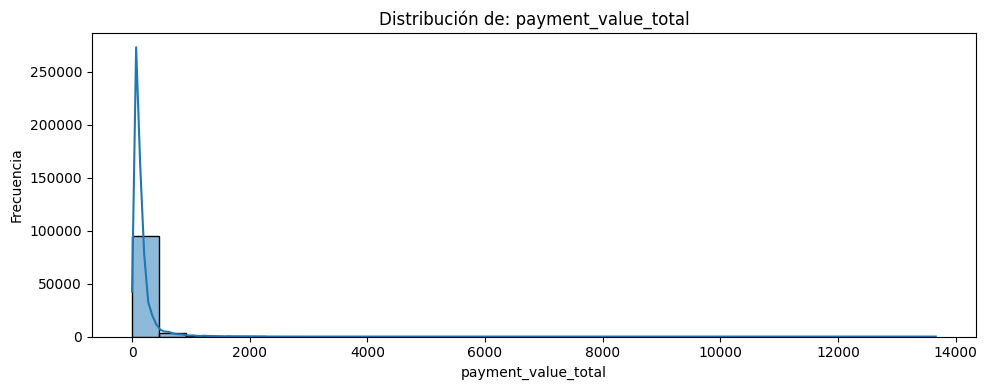

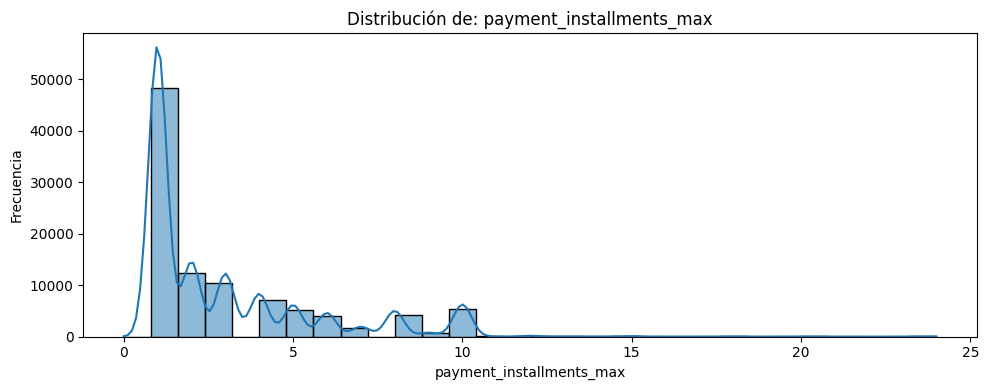

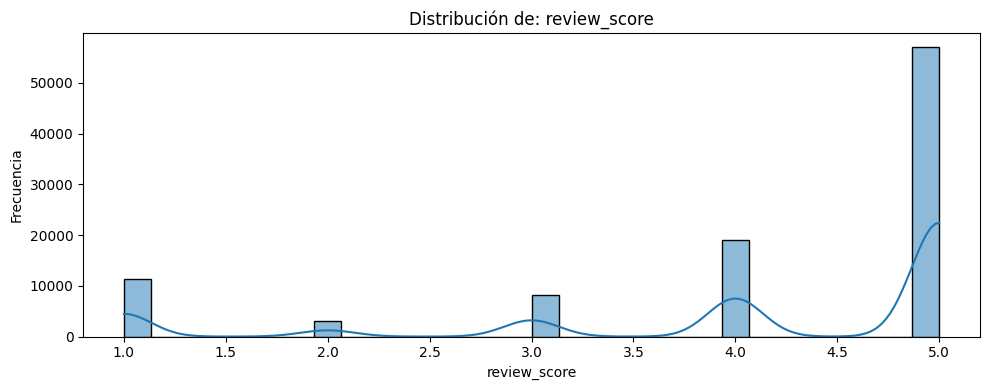

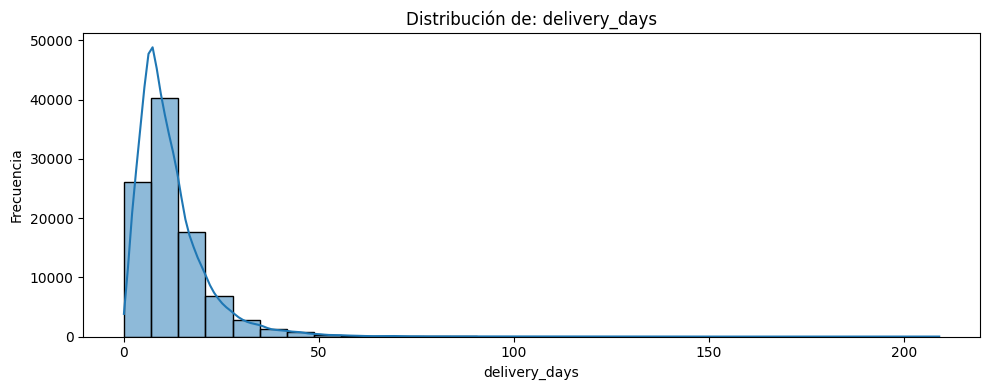

In [35]:
cols_numericas_fact_orders = fact_orders.select_dtypes(include=['number']).columns.tolist()

exclude_from_hist_orders = [
    'order_id', 'customer_id', 'customer_unique_id', 'is_late', 'customer_zip_code_prefix',
    'boxcox_payment_value_total', 'z_score_payment_value_total_boxcox', 'z_score_payment_value_total',
    'boxcox_imputed_payment_value_total', 'cleaned_payment_value_total',
    'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson', 'payment_value_total_orig',
    'boxcox_delivery_days', 'z_score_delivery_days_boxcox', 'z_score_delivery_days',
    'boxcox_imputed_delivery_days', 'cleaned_delivery_days',
    'yeojohnson_delivery_days', 'z_score_delivery_days_yeojohnson', 'delivery_days_orig',
    'customer_lat', 'customer_lng'
]

plot_cols_orders = [col for col in cols_numericas_fact_orders if col not in exclude_from_hist_orders and not col.startswith(('boxcox_', 'yeojohnson_', 'z_score_', 'cleaned_', 'delivery_days_'))]

# histograma de variables numericas
for col in plot_cols_orders:
    plt.figure(figsize=(10,4))
    sns.histplot(fact_orders[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribución de: {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

Gráficos de barra para variables numéricas discretas en fact_orders:


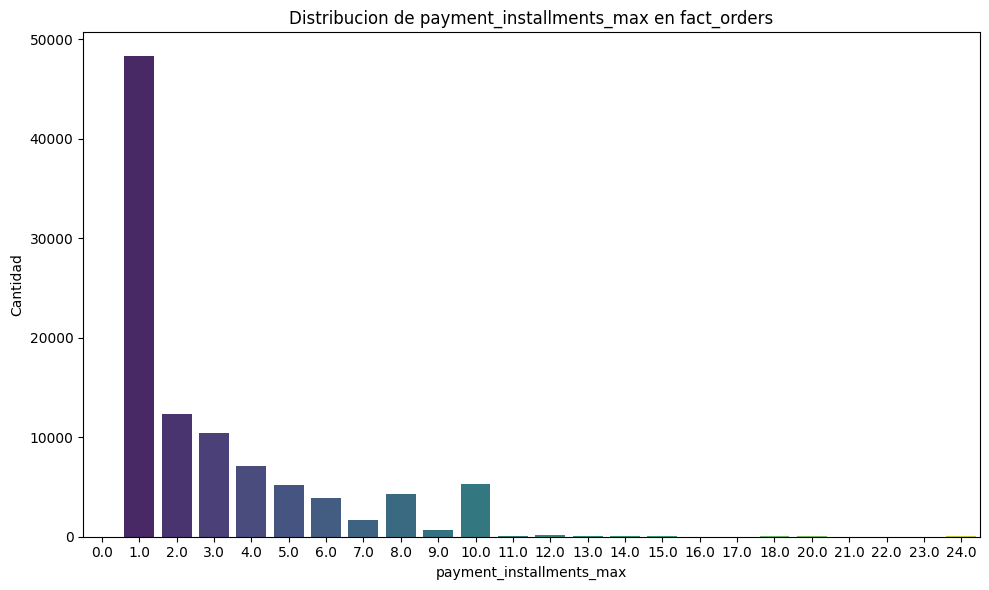

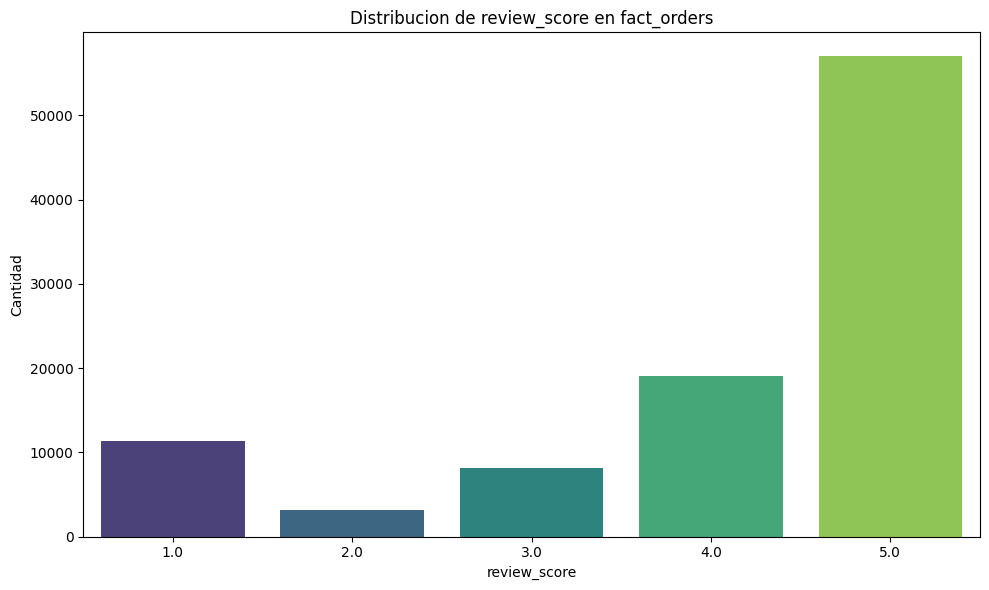

In [37]:
discrete_for_bar_chart_orders = ['payment_installments_max', 'review_score']

print("Gráficos de barra para variables numéricas discretas en fact_orders:")
for col in discrete_for_bar_chart_orders:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=fact_orders.dropna(subset=[col]), x=col, palette='viridis')
    plt.title(f'Distribucion de {col} en fact_orders')
    plt.xlabel(col)
    plt.ylabel('Cantidad')
    plt.tight_layout()
    plt.show()

###Análisis de duplicados, nulos y outliers.

In [39]:
print("Revisando duplicados en los dataframes originales:")
print("Duplicados en Orders:", orders.duplicated().sum())
print("Duplicados en Payments:", payments.duplicated().sum())
print("Duplicados en Reviews:", reviews.duplicated().sum())
print("Duplicados en Customers:", customers.duplicated().sum())
print("Duplicados en Geo:", geo.duplicated().sum())

print("\nRevisando duplicados en los dataframes agregados:")
print("Duplicados en Fact Orders:", fact_orders.duplicated().sum())

Revisando duplicados en los dataframes originales:
Duplicados en Orders: 0
Duplicados en Payments: 0
Duplicados en Reviews: 0
Duplicados en Customers: 0
Duplicados en Geo: 261831

Revisando duplicados en los dataframes agregados:
Duplicados en Fact Orders: 0


In [40]:
def top_nulls(df, k=10):
    return (df.isna().mean().mul(100).round(2)
            .sort_values(ascending=False).head(k))

print("Nulos fact_orders (top 10):\n", top_nulls(fact_orders))

Nulos fact_orders (top 10):
 review_comment_title             88.38
review_comment_message           58.93
order_delivered_customer_date     2.98
delivery_days                     2.98
order_delivered_carrier_date      1.79
review_score                      0.77
review_answer_timestamp           0.77
review_creation_date              0.77
customer_lat                      0.28
customer_lng                      0.28
dtype: float64


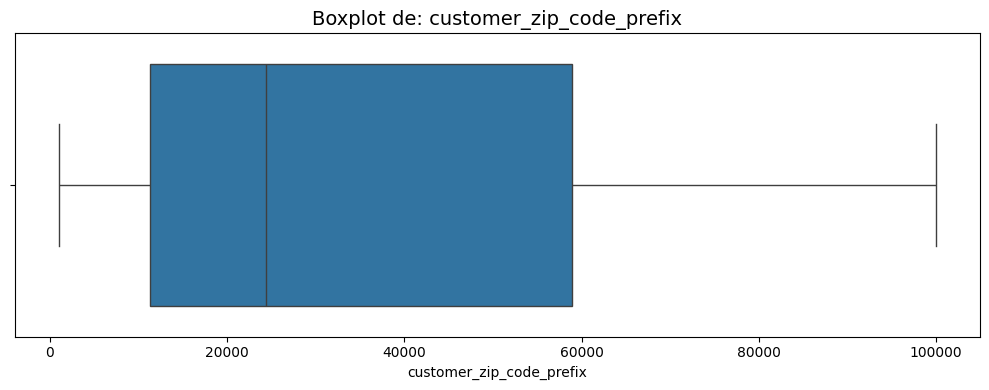

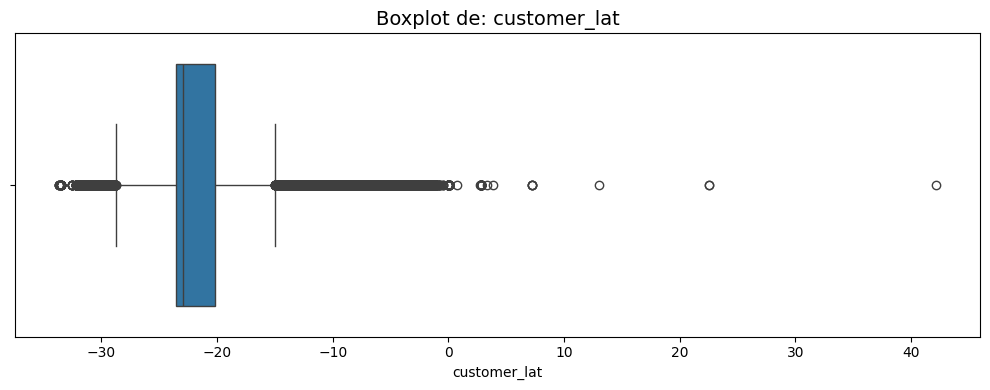

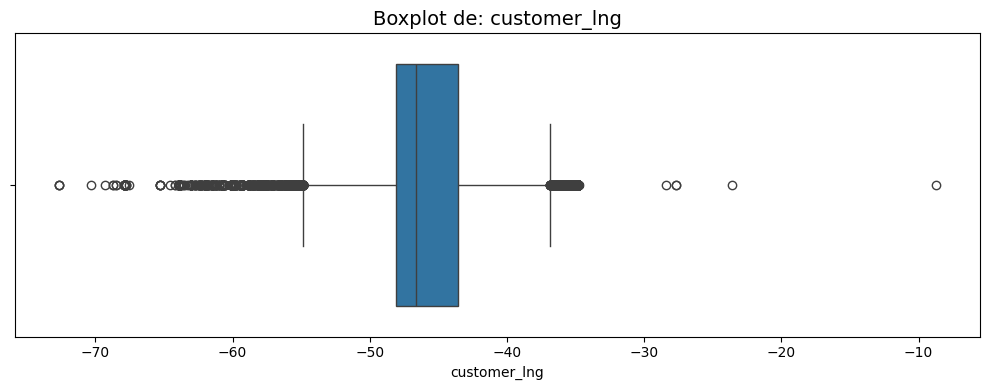

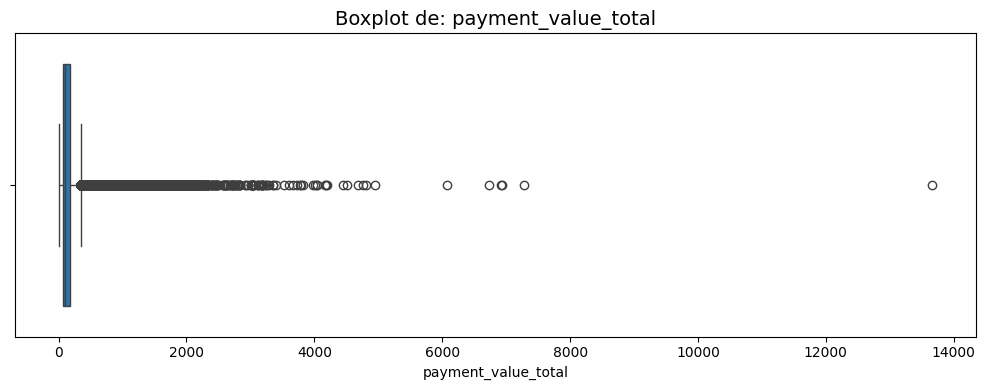

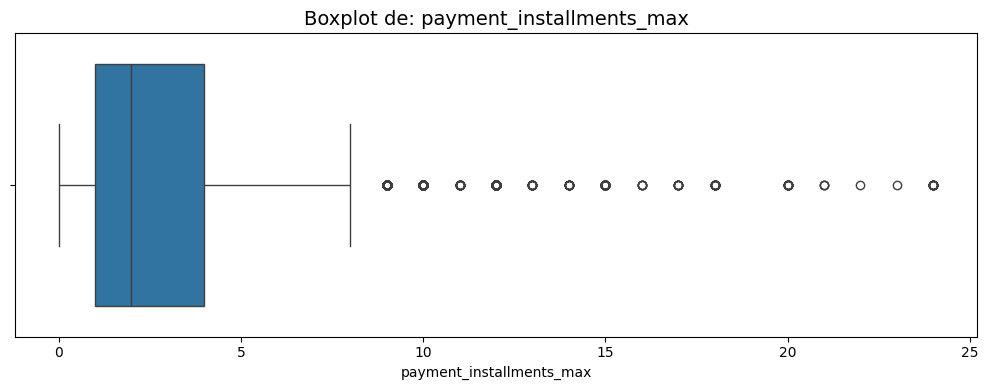

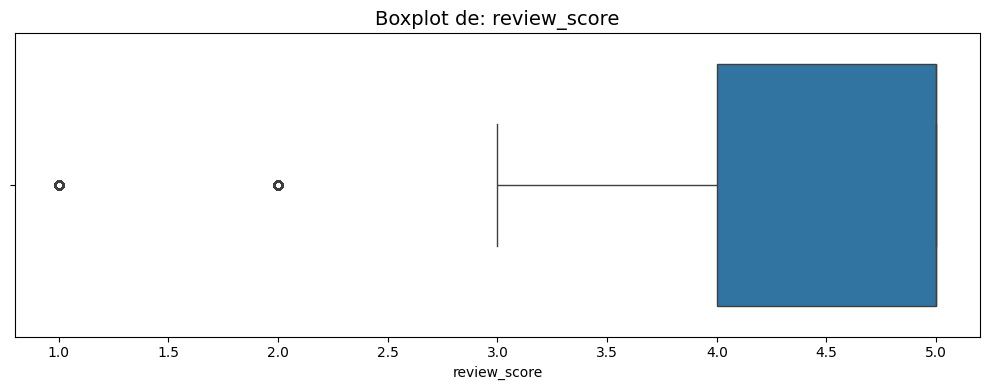

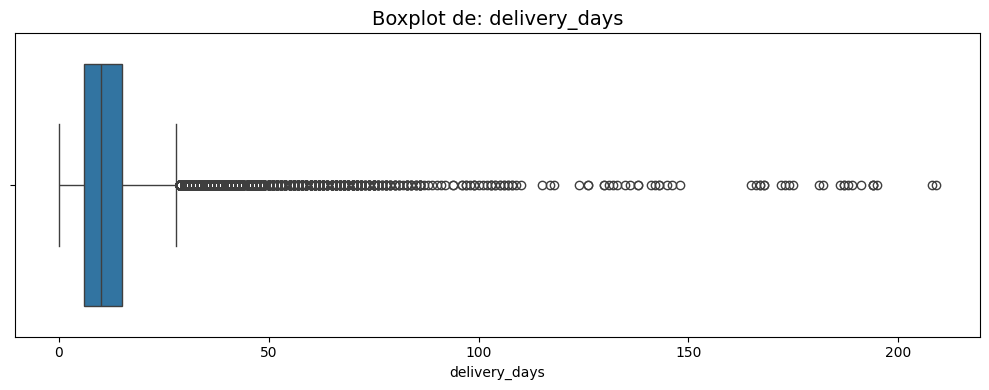

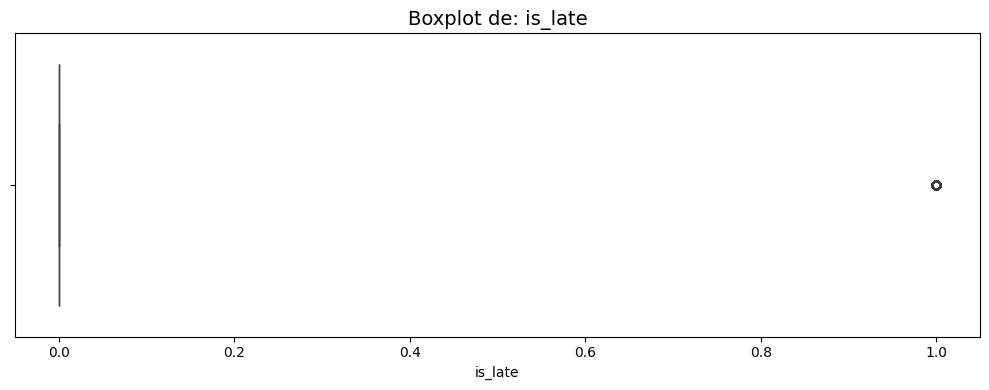

In [41]:
# boxplots para detectar outliers y ver la distribucion de las variables

cols_numericas_fact_orders = fact_orders.select_dtypes(include='number').columns

for col in cols_numericas_fact_orders:
    plt.figure(figsize=(10, 4))
    sns.boxplot(data=fact_orders, x=col)
    plt.title(f"Boxplot de: {col}", fontsize=14)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

In [42]:
# funcion para detectar outliers usando IQR
def detectar_outliers_iqr(df, columna, severos = False):
    if severos == True:
      sep = 3
    else:
      sep = 1.5
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - sep * IQR
    limite_superior = Q3 + sep * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers.index

qOutliers = 0
qOutliersSeveros = 0
df_outliers_severos = pd.DataFrame()

cols_numericas_fact_orders_no_geo = [col for col in cols_numericas_fact_orders if 'lat' not in col and 'lng' not in col]

for col in cols_numericas_fact_orders_no_geo:
    outliers = detectar_outliers_iqr(fact_orders, col)
    outliers_severos = detectar_outliers_iqr(fact_orders, col, severos=True)
    print(f"{col}: {len(outliers)} outliers totales ({len(outliers) / len(fact_orders) * 100:.2f}%)",
          f" y {len(outliers_severos)} outliers severos ({len(outliers_severos) / len(fact_orders) * 100:.2f}%)",sep='')
    qOutliers+= len(outliers)
    qOutliersSeveros+= len(outliers_severos)
    outliers_severos = pd.Series(outliers_severos.tolist())
    df_outliers_severos = pd.concat([df_outliers_severos,outliers_severos])

print(f'En total hay {qOutliers} outliers y {qOutliersSeveros} outliers severos')

customer_zip_code_prefix: 0 outliers totales (0.00%) y 0 outliers severos (0.00%)
payment_value_total: 7866 outliers totales (7.91%) y 3999 outliers severos (4.02%)
payment_installments_max: 6300 outliers totales (6.34%) y 169 outliers severos (0.17%)
review_score: 14493 outliers totales (14.57%) y 0 outliers severos (0.00%)
delivery_days: 5025 outliers totales (5.05%) y 1320 outliers severos (1.33%)
En total hay 33684 outliers y 5488 outliers severos


##Preprocesamiento inicial

###Tratamiento de nulos, duplicados y outliers. Definición de criterios de imputación y justificación.

En el caso de la latitud y longitud, decidimos excluirlos del analisis de outliers porque son direcciones y consideramos que no debiamos incluirlos.

In [43]:
fact_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  object        
 9   customer_zip_code_prefix       99441 non-null  int64         
 10  customer_city                  99441 non-null  object        
 11  customer_state 

Variable: payment_value_total
Shapiro-Wilk p-Valor: 4.035088331009864e-79
Variable: delivery_days
Shapiro-Wilk p-Valor: 4.856567782340027e-72


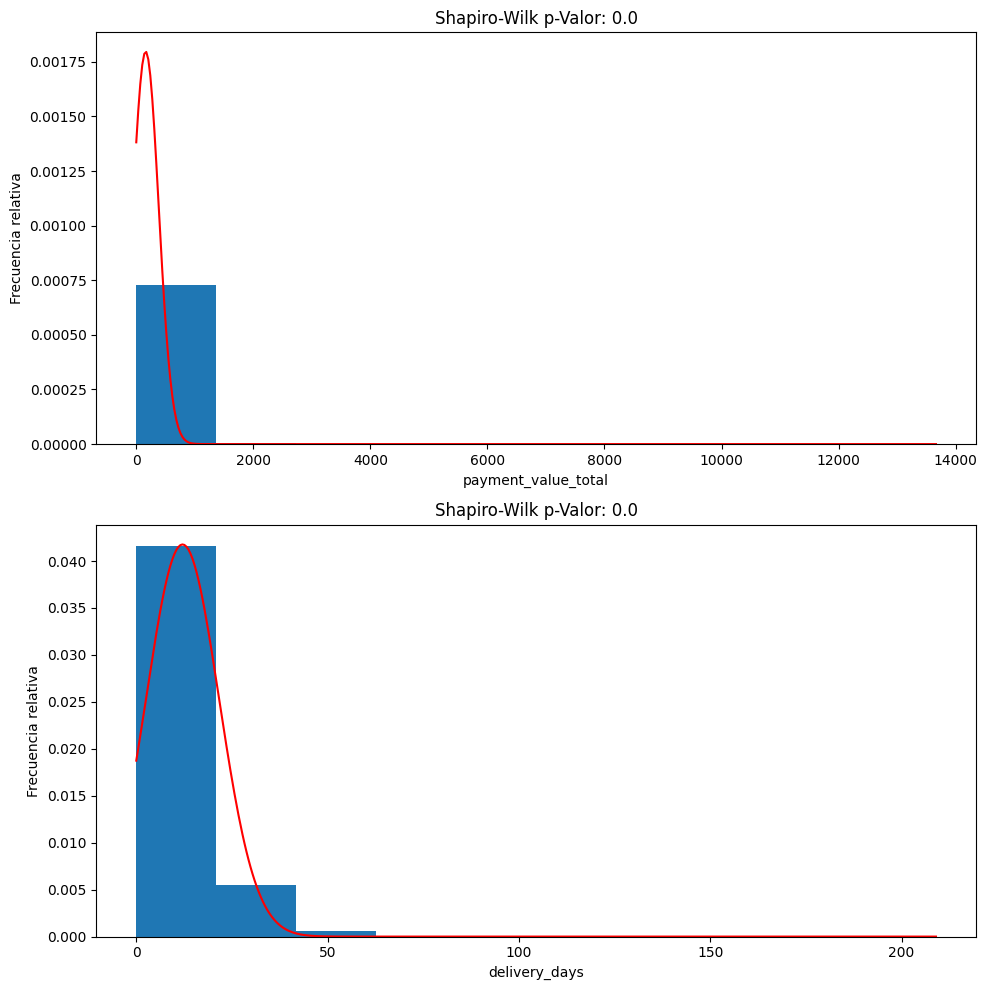

In [44]:
# analizamos los outliers de las variables cuantitativas continuas
# para eso, primero tenemos que ver si son normales

# H0 es que la variable sigue una distribucion normal
# H1 es que no sigue una distribucion normal

# CONTINUAS:
continuous_cols_orders = ['payment_value_total', 'delivery_days']


fig_orders, ax_orders = plt.subplots(len(continuous_cols_orders), 1, figsize=(10, 5 * len(continuous_cols_orders)))

for i, col in enumerate(continuous_cols_orders):
  data_filtered = fact_orders[col].replace([np.inf, -np.inf], np.nan).dropna()

  if len(data_filtered) > 0:
    muVar, sVar = stats.norm.fit(data_filtered)
    mAux = data_filtered.min()
    MAux = data_filtered.max()

    if len(data_filtered) > 5000:
        pvAux = stats.shapiro(data_filtered.sample(5000, random_state=42)).pvalue
    else:
        pvAux = stats.shapiro(data_filtered).pvalue

    print(f"Variable: {col}")
    print(f"Shapiro-Wilk p-Valor: {pvAux}")

    xseq = np.linspace(mAux, MAux, 400)
    yseq = stats.norm(muVar, sVar).pdf(xseq)

    ax_orders[i].hist(data_filtered, density=True)
    ax_orders[i].plot(xseq, yseq, c="r")
    ax_orders[i].set_ylabel("Frecuencia relativa")
    ax_orders[i].set_xlabel(col)
    ax_orders[i].set_title(f"Shapiro-Wilk p-Valor: {np.round(pvAux, 10)}")
  else:
      print(f"Variable: {col} no tiene datos validos despues del filtrado.")


fig_orders.tight_layout()
plt.show()

In [45]:
# analizamos los outliers de las variables cuantitativas continuas
# ahora, como NO son normales, aplicamos boxcox y luego buscamos los outliers con z score y umbral de 4 desviaciones estandar sobre la media

continuous_cols_orders = ['payment_value_total', 'delivery_days']


def aplicar_boxcox_z_score_outliers(df, cols, z_thresh=4.0):  # cols son las columnas que le paso
    for col in cols:
        if col not in df.columns:
            print(f"Columna '{col}' no encontrada en el dataframe.")
            continue

        # 1) Transformación Box–Cox (requiere > 0)
        data_positive = df[col].dropna()
        if (data_positive <= 0).any():
            print(f"Columna '{col}' contiene valores negativos. No se aplica Box-Cox directo.")
            continue

        sin_na = data_positive
        data_bc, lambda_bc = boxcox(sin_na)

        # Alinear índices
        df[f"boxcox_{col}"] = np.nan
        df.loc[sin_na.index, f"boxcox_{col}"] = data_bc

        # 2) Z-score en Box–Cox
        df[f"z_score_{col}_boxcox"] = zscore(df[f"boxcox_{col}"], nan_policy="omit")
        mask_out_bc = np.abs(df[f"z_score_{col}_boxcox"]) > z_thresh

        # 3) Z-score en escala original (solo para informar)
        df[f"z_score_{col}"] = zscore(df[col], nan_policy="omit")
        mask_out_raw = np.abs(df[f"z_score_{col}"]) > z_thresh

        # 4) Imputación: mediana en espacio Box–Cox (sobre NO-outliers)
        median_bc = np.median(df.loc[~mask_out_bc, f"boxcox_{col}"].dropna())
        df[f"boxcox_imputed_{col}"] = df[f"boxcox_{col}"].copy()
        df.loc[mask_out_bc, f"boxcox_imputed_{col}"] = median_bc

        # 5) Volver a escala original
        if abs(lambda_bc) > 1e-9:
             df[f"cleaned_{col}"] = inv_boxcox(df[f"boxcox_imputed_{col}"], lambda_bc)
        else:
             df[f"cleaned_{col}"] = np.exp(df[f"boxcox_imputed_{col}"])


        # 6) Reemplazar en variable original SOLO donde había outliers (según Box–Cox)
        df.loc[mask_out_bc, col] = df.loc[mask_out_bc, f"cleaned_{col}"]

        print(f"Cantidad de outliers en {col} con Box–Cox (|z|>{z_thresh}): {int(mask_out_bc.sum())}")
        print(f"Cantidad de outliers en {col} sin Box–Cox (|z|>{z_thresh}): {int(mask_out_raw.sum())}")
        print("-" * 50)

print("Aplicando deteccion de outlier Box-Cox y Z-score a fact_orders:")
aplicar_boxcox_z_score_outliers(fact_orders, continuous_cols_orders, z_thresh=4.0)

Aplicando deteccion de outlier  Box-Cox y Z-score a fact_orders:
Columna 'payment_value_total' contiene valores negativos. No se aplica Box-Cox directo.
Columna 'delivery_days' contiene valores negativos. No se aplica Box-Cox directo.


Podemos ver que hay algunas variables que tienen valores negativos, por lo tanto aplicaremos Yeo Johnson en vez de Box Cox.

In [46]:
# ahora usamos yeo johnson

continuous_cols_orders_yeo = ['payment_value_total', 'delivery_days']

def aplicar_yeojohnson_z_score_outliers(df, cols, z_thresh=4.0):  # cols son las columnas que le paso
    for col in cols:
        if col not in df.columns:
            print(f"Columna '{col}' no encontrada en el DataFrame.")
            continue

        # Transformación Yeo–Johnson (admite <= 0)
        sin_na = pd.to_numeric(df[col], errors="coerce").dropna()
        if len(sin_na) == 0:
            print(f"Columna '{col}' no tiene datos validos luego de eliminar nulos")
            continue

        data_yj, lambda_yj = yeojohnson(sin_na)

        # Alinear índices para guardar resultados
        df[f"yeojohnson_{col}"] = np.nan
        df.loc[sin_na.index, f"yeojohnson_{col}"] = data_yj

        # Z-score en Yeo–Johnson
        df[f"z_score_{col}_yeojohnson"] = zscore(df[f"yeojohnson_{col}"], nan_policy="omit")
        mask_out_yj = np.abs(df[f"z_score_{col}_yeojohnson"]) > z_thresh

        # Z-score en escala original (solo para informar)
        df[f"z_score_{col}"] = zscore(df[col], nan_policy="omit")
        mask_out_raw = np.abs(df[f"z_score_{col}"]) > z_thresh

        # Mediana en escala original usando NO-outliers (según YJ)
        med_orig = df.loc[~mask_out_yj, col].median()
        # Respaldo
        df[f"{col}_orig"] = df[col].copy()
        # Si la columna es entera, mantener tipo
        med_use = int(round(med_orig)) if pd.api.types.is_integer_dtype(df[col].dtype) else med_orig
        # Reemplazo en la variable ORIGINAL solo donde hay outliers (según YJ)
        df.loc[mask_out_yj, col] = med_use

        print(f"Cantidad de outliers en {col} con Yeo–Johnson (|z|>{z_thresh}): {int(mask_out_yj.sum())}")
        print(f"Cantidad de outliers en {col} sin transformación (|z|>{z_thresh}): {int(mask_out_raw.sum())}")
        print("-" * 50)

print("Aplicando deteccion de outlier Yeo-Johnson y Z-score a fact_orders:")
aplicar_yeojohnson_z_score_outliers(fact_orders, continuous_cols_orders_yeo, z_thresh=4.0)

Aplicando deteccion de outlier Yeo-Johnson y Z-score a fact_orders:
Cantidad de outliers en payment_value_total con Yeo–Johnson (|z|>4.0): 3
Cantidad de outliers en payment_value_total sin transformación (|z|>4.0): 1034
--------------------------------------------------
Cantidad de outliers en delivery_days con Yeo–Johnson (|z|>4.0): 43
Cantidad de outliers en delivery_days sin transformación (|z|>4.0): 611
--------------------------------------------------


Aplicamos BoxCox y Yeo Johnson. Ahora vamos a imputar los outliers detectados.

In [47]:
def chequear_outliers_post(df, cols_boxcox, cols_yeo, z_thresh=4.0):

    for col in cols_boxcox + cols_yeo:
        # b) Escala original (ya reemplazada)
        z_raw = zscore(pd.to_numeric(df[col], errors="coerce"), nan_policy="omit")
        rem_raw = int(np.nansum(np.abs(z_raw) > z_thresh))

        # a) Box–Cox imputado (si existe la columna)
        rem_bc = None
        bc_col = f"boxcox_imputed_{col}"
        if bc_col in df.columns:
            z_bc_imp = zscore(pd.to_numeric(df[bc_col], errors="coerce"), nan_policy="omit")
            rem_bc = int(np.nansum(np.abs(z_bc_imp) > z_thresh))

        # c) Yeo–Johnson (recalcular sobre la columna actual para chequear)
        x = pd.to_numeric(df[col], errors="coerce").dropna()
        if len(x) >= 3 and x.std(ddof=1) > 0:
            yj_vals, _ = yeojohnson(x)              # solo para detección
            z_yj = zscore(yj_vals, nan_policy="omit")
            rem_yj = int(np.sum(np.abs(z_yj) > z_thresh))
        else:
            rem_yj = 0

        if rem_bc is not None:
            print(f"[{col}] Restantes en Box–Cox imputado (|z|>{z_thresh}): {rem_bc}")
        else:
            print(f"[{col}] Box–Cox imputado no disponible (no se encontró '{bc_col}').")

        print(f"[{col}] Restantes en Yeo–Johnson (|z|>{z_thresh}): {rem_yj}")
        print(f"[{col}] Restantes en escala original (|z|>{z_thresh}): {rem_raw}")
        print("-"*50)

continuous_cols_orders_boxcox = []
continuous_cols_orders_yeo = ['payment_value_total', 'delivery_days']



print("Chequeando outliers restantes en fact_orders:")
chequear_outliers_post(fact_orders, continuous_cols_orders_boxcox, continuous_cols_orders_yeo, z_thresh=4.0)


Chequeando outliers restantes en fact_orders:
[payment_value_total] Box–Cox imputado no disponible (no se encontró 'boxcox_imputed_payment_value_total').
[payment_value_total] Restantes en Yeo–Johnson (|z|>4.0): 0
[payment_value_total] Restantes en escala original (|z|>4.0): 1034
--------------------------------------------------
[delivery_days] Box–Cox imputado no disponible (no se encontró 'boxcox_imputed_delivery_days').
[delivery_days] Restantes en Yeo–Johnson (|z|>4.0): 3
[delivery_days] Restantes en escala original (|z|>4.0): 694
--------------------------------------------------


Luego de imputar con la mediana, podemos ver que la cantidad de outliers queda en 0 en casi todos los casos o se reduce.

In [ ]:
##AHORA ANALIZAMOS LAS DISCRETAS

In [48]:
discrete_cols_orders = fact_orders.select_dtypes(include=['int64', 'Int8']).columns.tolist()
exclude_cols_orders = ['customer_zip_code_prefix', 'is_late']

discrete_cols_to_analyze_orders = [col for col in discrete_cols_orders if col not in exclude_cols_orders]

print("Analizando outliers en columnas numericas discretas de fact_orders:")
discrete_cols_with_outliers_orders = []
for col in discrete_cols_to_analyze_orders:
    outliers = detectar_outliers_iqr(fact_orders, col)
    outliers_severos = detectar_outliers_iqr(fact_orders, col, severos=True)
    num_outliers = len(outliers)
    num_outliers_severos = len(outliers_severos)

    print(f"{col}: {num_outliers} outliers totales ({num_outliers / len(fact_orders) * 100:.2f}%)",
          f" y {num_outliers_severos} outliers severos ({num_outliers_severos / len(fact_orders) * 100:.2f}%)",sep='')

    if num_outliers > 0:
        discrete_cols_with_outliers_orders.append(col)

print("\nColumnas discretas de fact_orders con outliers:", discrete_cols_with_outliers_orders)



Analizando outliers en columnas numericas discretas de fact_orders:

Columnas discretas de fact_orders con outliers: []


In [49]:
fact_tables = {
    "fact_orders": fact_orders
}


for df_name, df in fact_tables.items():
    n = len(df)
    falt = df.isna().sum()
    falt = falt[falt > 0]
    falt_pct = (falt / n) * 100

    faltantes_df = (
        pd.DataFrame({"Cantidad_faltantes": falt, "Porcentaje": falt_pct})
        .sort_values("Porcentaje", ascending=False)
    )

    if not faltantes_df.empty:
        faltantes_df["Porcentaje"] = faltantes_df["Porcentaje"].map(lambda x: f"{x:.2f}%")
        print(f"\nValores faltantes en '{df_name}':")
        display(faltantes_df)
    else:
        print(f"\nNo hay valores faltantes en '{df_name}'")


Valores faltantes en 'fact_orders':


,Cantidad_faltantes,Porcentaje
review_comment_title,87888,88.38%
review_comment_message,58605,58.93%
order_delivered_customer_date,2965,2.98%
z_score_delivery_days,2965,2.98%
delivery_days_orig,2965,2.98%
delivery_days,2965,2.98%
z_score_delivery_days_yeojohnson,2965,2.98%
yeojohnson_delivery_days,2965,2.98%
order_delivered_carrier_date,1783,1.79%
review_creation_date,768,0.77%



Matriz de valores faltantes para 'fact_orders':


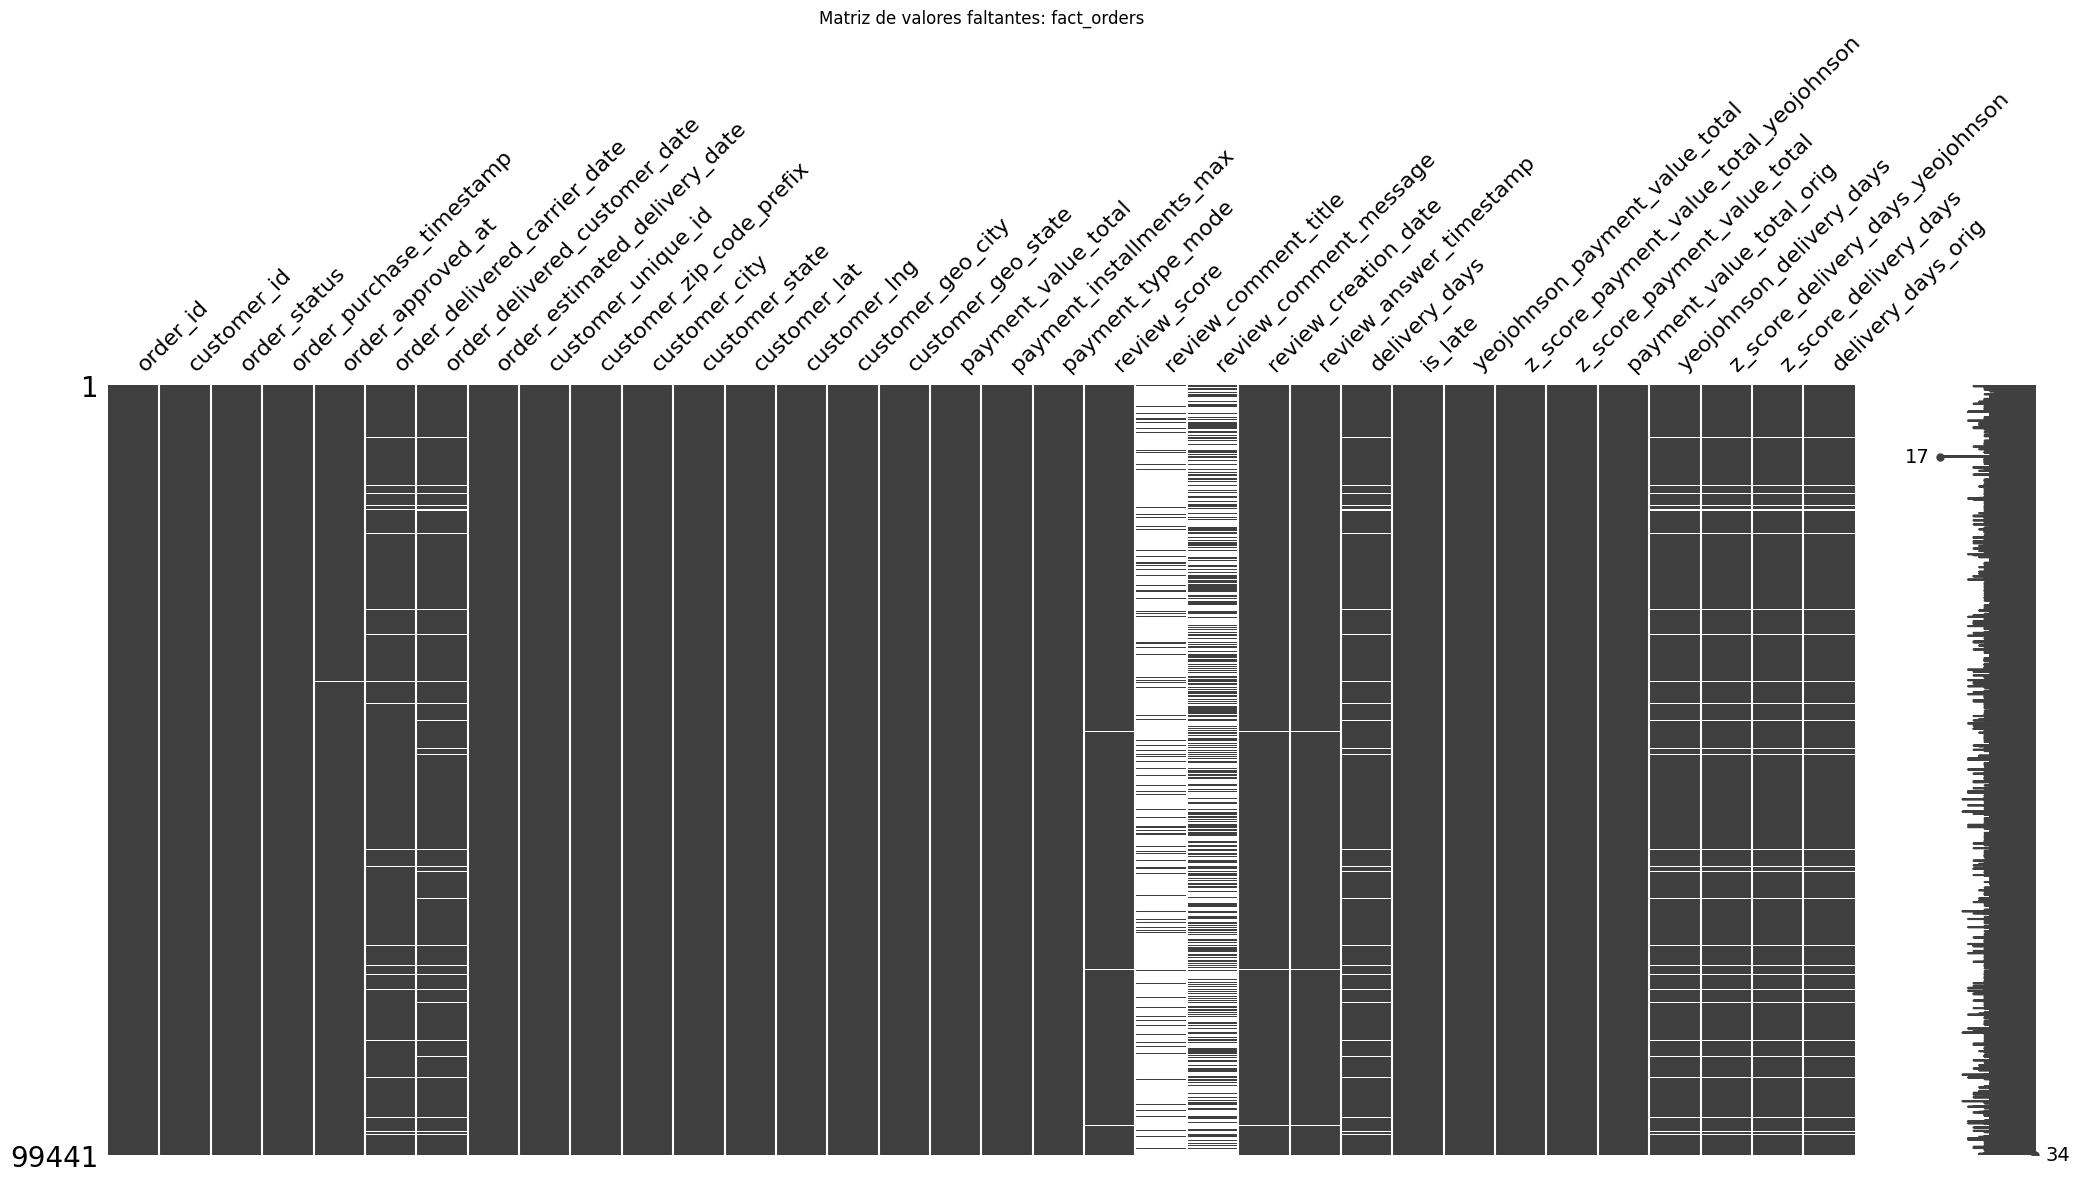

In [50]:
try:

    fact_tables = {
        "fact_orders": fact_orders
    }

    for df_name, df in fact_tables.items():
        print(f"\nMatriz de valores faltantes para '{df_name}':")
        msno.matrix(df)
        plt.title(f"Matriz de valores faltantes: {df_name}")
        plt.show()

except ImportError:
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna().T, cbar=False, cmap="Blues")
    plt.title(f"Mapa simple de faltantes ({df_name} - todas las columnas)")
    plt.ylabel("Variables")
    plt.xlabel("Observaciones")
    plt.show()
except Exception as e:
    print(f"Error: {e}")
    plt.figure(figsize=(12,4))
    sns.heatmap(df.isna().T, cbar=False, cmap="Blues")
    plt.title(f"Mapa simple de faltantes ({df_name} - todas las columnas)")
    plt.ylabel("Variables")
    plt.xlabel("Observaciones")
    plt.show()

Podemos ver que las columnas de titulo de la review y la review en si tienen muchos valores nulos, y como no vamos a hacer analisis de texto, decidimos eliminarlas.

In [51]:
columns_to_drop = ['review_comment_title', 'review_comment_message']

fact_orders = fact_orders.drop(columns=columns_to_drop)

print("Shape de fact_orders despues de eliminar las columnas:", fact_orders.shape)

Shape de fact_orders despues de eliminar las columnas: (99441, 32)


In [53]:
def littles_mcar_test(df):
    numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
    exclude_cols = ['order_id', 'customer_id', 'review_comment_title', 'review_comment_message',
                    'order_item_id', 'product_id', 'seller_id', 'customer_unique_id',
                    'customer_zip_code_prefix', 'seller_zip_code_prefix']

    use_cols = [col for col in numerical_cols if col not in exclude_cols]

    if not use_cols:
        print("No hay columnas numericas adecuadas para MCAR test.")
        return np.nan, 0, np.nan


    X = df[use_cols].copy().replace({pd.NA: np.nan})

    missing_mask = X.isna()

    imp_mean = SimpleImputer(strategy="mean")
    X_imp = pd.DataFrame(imp_mean.fit_transform(X), columns=use_cols, index=X.index)

    patterns = missing_mask.drop_duplicates()
    chi_square = 0.0
    dof = 0

    for _, pattern in patterns.iterrows():
        rows = missing_mask.eq(pattern, axis=1).all(axis=1)
        subset = X.loc[rows]
        if subset.empty:
            continue

        means = X_imp.loc[rows, use_cols].mean()
        diffs = subset[use_cols].fillna(0) - means

        chi_square += (diffs**2).to_numpy().sum()
        dof += diffs.size

    p_value = 1 - chi2.cdf(chi_square, dof) if dof > 0 else np.nan
    return chi_square, dof, p_value

chi2_stat_orders, dof_orders, p_orders = littles_mcar_test(fact_orders)
print(f"Chi2: {chi2_stat_orders:.2f}")
print(f"Grados de libertad: {dof_orders}")
print(f"p-valor: {p_orders:.4f}")

if np.isnan(p_orders):
    print("No se pudo calcular pvalue para fact orders.")
elif p_orders < 0.05:
    print("Se rechaza H0 (los valores faltantes son NOT MCAR) para fact_orders.")
else:
    print("No se rechaza H0 (los valores faltantes son MCAR) para fact_orders.")



Chi2: 9810921080.21
Grados de libertad: 1491615
p-valor: 0.0000
Se rechaza H0 (los valores faltantes son NOT MCAR) para fact_orders.


In [54]:
# se rechaza que sean MCAR, ahora vamos a ver si hay indicios de MAR
# para eso hacemos regresion

def logit_missing(df, target_col, original_numerical_cols):
    y = df[target_col].isna().astype(int)

    exclude_cols_predictors = [target_col, 'order_id', 'customer_id', 'order_item_id',
                               'product_id', 'seller_id', 'customer_unique_id',
                               'customer_zip_code_prefix', 'seller_zip_code_prefix',
                               'delivery_days', 'delivery_days_real',
                               'delivery_delay_orig']


    use_cols_predictors = [col for col in original_numerical_cols if col != target_col and col not in exclude_cols_predictors]

    if not use_cols_predictors:
        print(f"No se encontraron columnas numericas originales para usar como predictoras para {target_col}.")
        return None

    X_num = df[use_cols_predictors].apply(pd.to_numeric, errors="coerce").astype(float)

    X = sm.add_constant(X_num, has_constant="add")

    mask = X.notna().all(axis=1) & y.notna()
    X2, y2 = X.loc[mask], y.loc[mask]

    if X2.empty or len(X2.columns) < 2:
         print(f"No hay suficiente data valida o predictores para construir un modelo para {target_col}.")
         return None

    try:
        X2 = X2.dropna(axis=1)
        if X2.empty:
            print(f"No hay columnas preductoras validas restantes despues de eliminar nulos para {target_col}.")
            return None
        y2 = y.loc[X2.index].astype(int)
        modelo = sm.Logit(y2, X2).fit(disp=0)
        print(f"\n=== Logit missing({target_col}) ===")
        print(modelo.summary())
        return modelo
    except Exception as e:
        print(f"No se pudo construir el modelo logico para {target_col}: {e}")
        return None


current_numerical_cols_orders = fact_orders.select_dtypes(include=np.number).columns.tolist()
original_numerical_cols_orders = [col for col in current_numerical_cols_orders if not any(keyword in col for keyword in ['boxcox', 'yeojohnson', 'z_score', 'cleaned', '_orig', 'delivery_days', 'delivery_delay', 'delivery_days_real', 'delivery_delay_orig'])]


missing_cols_orders_numerical_original = [col for col in fact_orders.columns[fact_orders.isna().any()].tolist() if col in original_numerical_cols_orders]



logit_models_orders = {}
for col in missing_cols_orders_numerical_original:
    model = logit_missing(fact_orders, col, original_numerical_cols_orders)
    if model:
        logit_models_orders[col] = model


No se pudo construir el modelo logico para customer_lat: Singular matrix

=== Logit missing(customer_lng) ===
                           Logit Regression Results                           
Dep. Variable:           customer_lng   No. Observations:                98396
Model:                          Logit   Df Residuals:                    98390
Method:                           MLE   Df Model:                            5
Date:                Tue, 25 Nov 2025   Pseudo R-squ.:                     inf
Time:                        14:11:33   Log-Likelihood:            -3.3322e-08
converged:                      False   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -22.8700   3.93e+04     -0.001      1.000    

In [55]:
def interpret_mar_logit_results(model, col_name, alpha=0.05):
    if model is None:
        print("El modelo no se ajustó correctamente, no se pueden interpretar los resultados para", col_name)
        return

    print(f"\nInterpretación para los valores faltantes en '{col_name}':")

    significant_predictors = []
    for param, p_value in model.pvalues.items():
        if param != 'const' and p_value < alpha:
            significant_predictors.append(param)

    if significant_predictors:
        print(f"Evidencia de MAR: la falta de valores en '{col_name}' está significativamente relacionada con los siguientes predictores (p < {alpha}):")
        for predictor in significant_predictors:
            print(f"- {predictor} (p-valor: {model.pvalues[predictor]:.4f})")
    else:
        print(f"No se encontró una relación significativa entre los valores faltantes en '{col_name}' y los predictores numéricos incluidos (con alfa={alpha}).")
        print("Esto *podría* ser una indicación de MNAR para esta columna, pero no es concluyente.")
        print("La falta de valores podría estar relacionada con otras variables no incluidas o con el valor faltante en sí.")

print("Interpretando los resultados del análisis MAR para fact_orders:")
for col, model in logit_models_orders.items():
    interpret_mar_logit_results(model, col)
    print("-" * 50)

Interpretando los resultados del análisis MAR para fact_orders:

Interpretación para los valores faltantes en 'customer_lng':
No se encontró una relación significativa entre los valores faltantes en 'customer_lng' y los predictores numéricos incluidos (con alfa=0.05).
Esto *podría* ser una indicación de MNAR para esta columna, pero no es concluyente.
La falta de valores podría estar relacionada con otras variables no incluidas o con el valor faltante en sí.
--------------------------------------------------

Interpretación para los valores faltantes en 'payment_value_total':
No se encontró una relación significativa entre los valores faltantes en 'payment_value_total' y los predictores numéricos incluidos (con alfa=0.05).
Esto *podría* ser una indicación de MNAR para esta columna, pero no es concluyente.
La falta de valores podría estar relacionada con otras variables no incluidas o con el valor faltante en sí.
--------------------------------------------------

Interpretación para los

Hicimos la regresión logística sobre las variables numéricas. En la mayoría de los casos,no rechazamos H0 (todos los p valores eran grandes), por lo que no podíamos afirmar que los datos fueran MAR.

Entonces, consideramos que al tratarse de una cantidad menor al 3% de faltantes por columna, aplicamos KNN en todos los casos porque no consideramos que el test fuera tan concluyente ya que la cantidad de datos faltantes era poca.

En conclusión, aplicamos KNN en todos los casos, en las columnas no numéricas de texto imputamos con la moda y en las de fecha y hora rellenamos con NaT, que es un dato nulo pero de tiempo.

In [56]:
numerical_cols_with_missing_orders = fact_orders.select_dtypes(include=np.number).columns[fact_orders.select_dtypes(include=np.number).isna().any()].tolist()
exclude_cols_impute_orders = ['customer_zip_code_prefix']

numerical_cols_to_impute_knn_orders = [col for col in numerical_cols_with_missing_orders if col not in exclude_cols_impute_orders]



print("Aplicando imputación KNN a columnas numéricas en fact_orders:")
if numerical_cols_to_impute_knn_orders:
    imputer_orders = KNNImputer(n_neighbors=5)
    fact_orders[numerical_cols_to_impute_knn_orders] = imputer_orders.fit_transform(fact_orders[numerical_cols_to_impute_knn_orders])
    print("Imputación KNN aplicada a:", numerical_cols_to_impute_knn_orders)
else:
    print("No se encontraron columnas numéricas adecuadas en fact_orders para la imputación KNN.")

Aplicando imputación KNN a columnas numéricas en fact_orders:
Imputación KNN aplicada a: ['customer_lat', 'customer_lng', 'payment_value_total', 'payment_installments_max', 'review_score', 'delivery_days', 'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson', 'z_score_payment_value_total', 'payment_value_total_orig', 'yeojohnson_delivery_days', 'z_score_delivery_days_yeojohnson', 'z_score_delivery_days', 'delivery_days_orig']


In [57]:
categorical_cols_to_impute_mode_orders = ['customer_geo_city', 'customer_geo_state', 'payment_type_mode']

print("Aplicando imputación por moda a columnas categóricas en fact_orders:")
for col in categorical_cols_to_impute_mode_orders:
    if col in fact_orders.columns and fact_orders[col].isna().any():
        mode_value = fact_orders[col].mode()[0]
        fact_orders[col] = fact_orders[col].fillna(mode_value)
        print(f"Imputación por moda aplicada a '{col}' en fact_orders.")
    elif col not in fact_orders.columns:
        print(f"Columna '{col}' no encontrada en fact_orders. Saltando la imputación por moda.")
    else:
         print(f"La columna '{col}' en fact_orders no tiene valores faltantes. Saltando la imputación por moda.")

Aplicando imputación por moda a columnas categóricas en fact_orders:
Imputación por moda aplicada a 'customer_geo_city' en fact_orders.
Imputación por moda aplicada a 'customer_geo_state' en fact_orders.
Imputación por moda aplicada a 'payment_type_mode' en fact_orders.


In [58]:
date_cols_to_impute_orders = ['order_delivered_customer_date', 'order_delivered_carrier_date', 'order_approved_at', 'review_creation_date', 'review_answer_timestamp']

print("Aplicando imputación NaT a las columnas de fecha/hora en fact_orders:")
for col in date_cols_to_impute_orders:
    if col in fact_orders.columns and fact_orders[col].isna().any():
        fact_orders[col] = pd.to_datetime(fact_orders[col], errors='coerce')
        fact_orders[col] = fact_orders[col].fillna(pd.NaT)
        print(f"Imputación NaT aplicada a '{col}' en fact_orders.")
    elif col not in fact_orders.columns:
        print(f"Columna '{col}' no encontrada en fact_orders. Saltando la imputación NaT.")
    else:
        print(f"La columna '{col}' en fact_orders no tiene valores faltantes. Saltando la imputación NaT.")

Aplicando imputación NaT a las columnas de fecha/hora en fact_orders:
Imputación NaT aplicada a 'order_delivered_customer_date' en fact_orders.
Imputación NaT aplicada a 'order_delivered_carrier_date' en fact_orders.
Imputación NaT aplicada a 'order_approved_at' en fact_orders.
Imputación NaT aplicada a 'review_creation_date' en fact_orders.
Imputación NaT aplicada a 'review_answer_timestamp' en fact_orders.


In [59]:
fact_tables = {
    "fact_orders": fact_orders
}

print("Verificando si quedan valores faltantes en las tablas de hechos después de la imputación:")

all_missing_handled = True
for df_name, df in fact_tables.items():
    n = len(df)
    falt = df.isna().sum()
    falt = falt[falt > 0]

    if not falt.empty:
        all_missing_handled = False
        falt_pct = (falt / n) * 100
        faltantes_df = (
            pd.DataFrame({"Cantidad_faltantes": falt, "Porcentaje": falt_pct})
            .sort_values("Porcentaje", ascending=False)
        )
        faltantes_df["Porcentaje"] = faltantes_df["Porcentaje"].map(lambda x: f"{x:.2f}%")
        print(f"\nSe encontraron valores faltantes restantes en el dataframe '{df_name}':")
        display(faltantes_df)
    else:
        print(f"\nNo se encontraron valores faltantes restantes en el dataframe '{df_name}'.")

if all_missing_handled:
    print("\nTodos los valores faltantes previstos parecen haber sido manejados.")
else:
    print("\nTodavía hay algunos valores faltantes que pueden requerir mayor atención.")

Verificando si quedan valores faltantes en las tablas de hechos después de la imputación:

Se encontraron valores faltantes restantes en el dataframe 'fact_orders':


,Cantidad_faltantes,Porcentaje
order_delivered_customer_date,2965,2.98%
order_delivered_carrier_date,1783,1.79%
review_creation_date,768,0.77%
review_answer_timestamp,768,0.77%
order_approved_at,160,0.16%



Todavía hay algunos valores faltantes que pueden requerir mayor atención.


##Análisis exploratorio inicial con visualizaciones.

,customer_zip_code_prefix,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late
customer_zip_code_prefix,1.000000,0.125477,-0.304201,0.057795,0.055175,-0.015816,0.282872,0.024429
customer_lat,0.125477,1.000000,0.450095,0.069126,0.063706,-0.042001,0.265111,0.055468
customer_lng,-0.304201,0.450095,1.000000,0.019477,0.040252,-0.052258,0.120331,0.072228
payment_value_total,0.057795,0.069126,0.019477,1.000000,0.319081,-0.048911,0.071603,0.015457
payment_installments_max,0.055175,0.063706,0.040252,0.319081,1.000000,-0.031036,0.052885,0.008576
review_score,-0.015816,-0.042001,-0.052258,-0.048911,-0.031036,1.000000,-0.357467,-0.330312
delivery_days,0.282872,0.265111,0.120331,0.071603,0.052885,-0.357467,1.000000,0.587799
is_late,0.024429,0.055468,0.072228,0.015457,0.008576,-0.330312,0.587799,1.000000


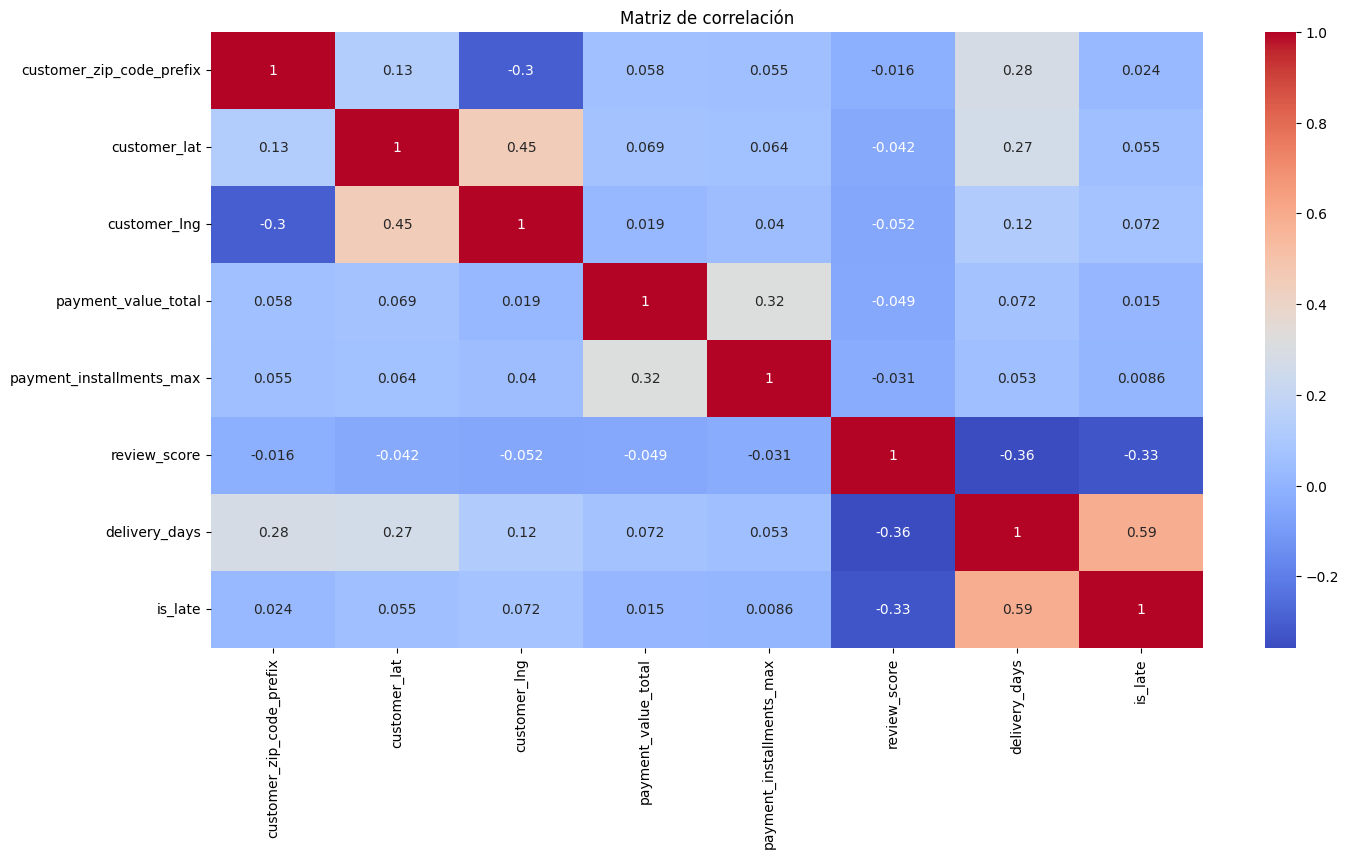

In [ ]:
cols_to_exclude = ['z_score_payment_value_total_yeojohnson', 'z_score_payment_value_total',
                   'payment_value_total_orig', 'z_score_delivery_days_yeojohnson',
                   'z_score_delivery_days', 'delivery_days_orig', 'yeojohnson_payment_value_total',
                   'yeojohnson_delivery_days']

fact_orders_filtered = fact_orders.drop(columns=cols_to_exclude, errors='ignore')

# calcular correlaciones
corr = fact_orders_filtered.corr(numeric_only=True)
display(corr)

plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

Consideramos que las variables están altamente correlaciones si la correlación es 0.8 o 80%. No se ven variables altamente correlacionadas, entonces no eliminamos.

###Gráficos básicos que permitan contrastar hipótesis.

Decidimos dejar solamente los graficos utilizados para sacar conclusiones, el detalle se encuentra en TP_descriptiva_Fact_Orders_DETALLE

In [66]:
order_total_payment = fact_orders.groupby('order_id')['payment_value_total'].sum().reset_index()
order_total_payment.rename(columns={'payment_value_total': 'order_total_value'}, inplace=True)

fact_orders_with_value = pd.merge(fact_orders, order_total_payment, on='order_id', how='left')

customer_avg_ticket = fact_orders_with_value.groupby('customer_unique_id')['order_total_value'].mean().reset_index()
customer_avg_ticket.rename(columns={'order_total_value': 'avg_ticket_price'}, inplace=True)

customer_purchase_frequency = fact_orders.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_purchase_frequency.rename(columns={'order_id': 'purchase_frequency'}, inplace=True)


customer_payment_counts = fact_orders.groupby(['customer_unique_id', 'payment_type_mode']).size().reset_index(name='count')

customer_preferred_payment = customer_payment_counts.loc[customer_payment_counts.groupby('customer_unique_id')['count'].idxmax()].reset_index(drop=True)
customer_preferred_payment.rename(columns={'payment_type_mode': 'preferred_payment_type'}, inplace=True)

customer_metrics = pd.merge(customer_avg_ticket, customer_purchase_frequency, on='customer_unique_id', how='left')
customer_metrics = pd.merge(customer_metrics, customer_preferred_payment[['customer_unique_id', 'preferred_payment_type']], on='customer_unique_id', how='left')


display(customer_metrics.head())

,customer_unique_id,avg_ticket_price,purchase_frequency,preferred_payment_type
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,credit_card
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,credit_card
2,0000f46a3911fa3c0805444483337064,86.22,1,credit_card
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,credit_card
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,credit_card


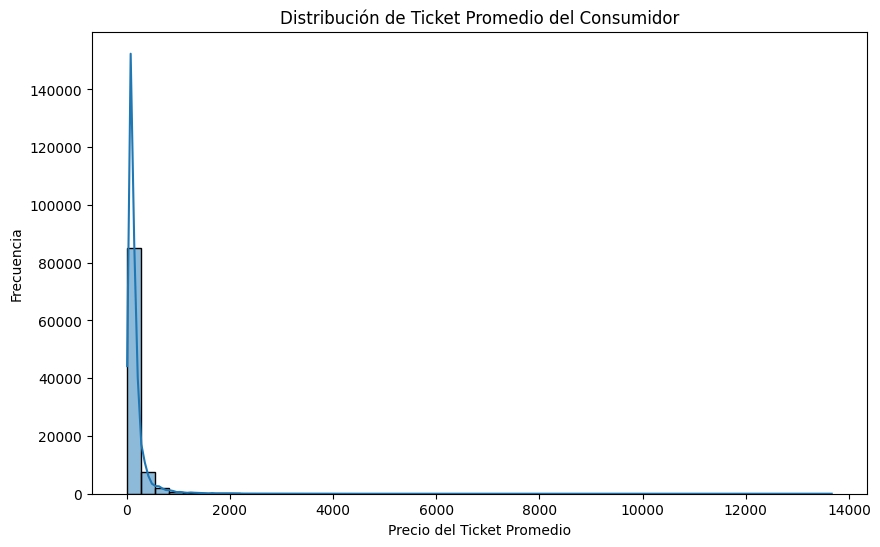

In [68]:
plt.figure(figsize=(10, 6))
sns.histplot(customer_metrics['avg_ticket_price'], bins=50, kde=True)
plt.title('Distribución de Ticket Promedio del Consumidor')
plt.xlabel('Precio del Ticket Promedio')
plt.ylabel('Frecuencia')
plt.show()

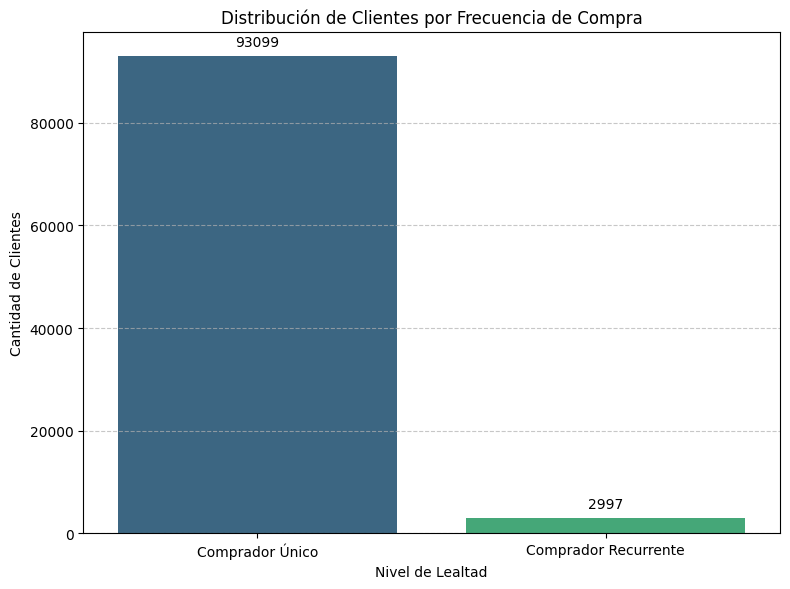

In [67]:
customer_metrics['loyalty_level'] = customer_metrics['purchase_frequency'].apply(lambda x: 'Repeat Buyer' if x > 1 else 'One-Time Buyer')

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=customer_metrics, x='loyalty_level', palette='viridis', hue='loyalty_level', legend=False)
plt.title('Distribución de Clientes por Frecuencia de Compra')
plt.xlabel('Nivel de Lealtad')
plt.ylabel('Cantidad de Clientes')
plt.xticks(ticks=[0, 1], labels=['Comprador Único', 'Comprador Recurrente'])
plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

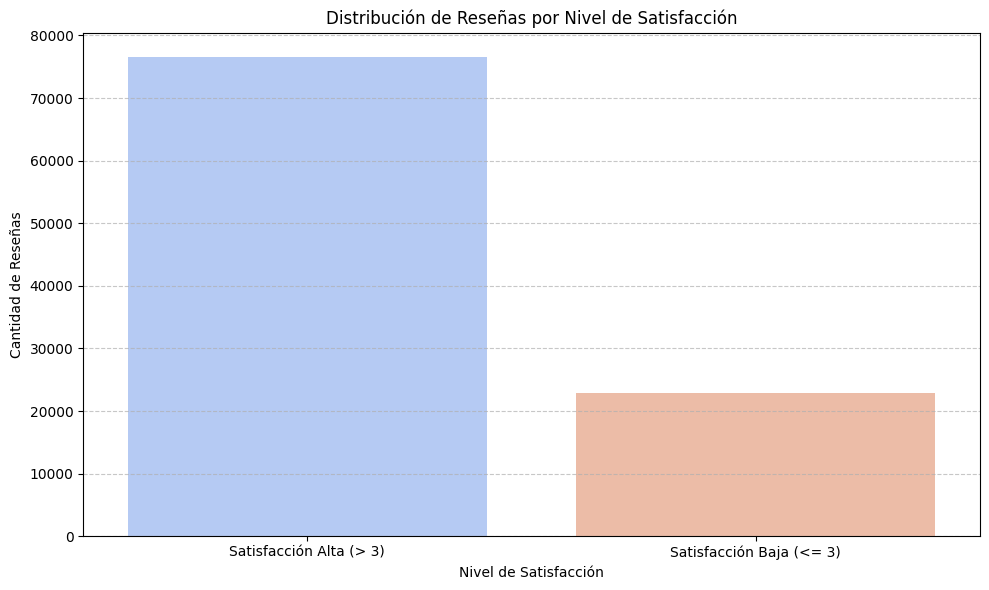

In [69]:
df_reviews = fact_orders.dropna(subset=['review_score']).copy()



df_reviews['satisfaction_level'] = df_reviews['review_score'].apply(lambda score: 'Satisfacción Baja (<= 3)' if score <= 3 else 'Satisfacción Alta (> 3)')

plt.figure(figsize=(10, 6))
sns.countplot(data=df_reviews, x='satisfaction_level', palette='coolwarm', hue='satisfaction_level', legend=False)
plt.title('Distribución de Reseñas por Nivel de Satisfacción') # Título del gráfico
plt.xlabel('Nivel de Satisfacción') # Etiqueta del eje X
plt.ylabel('Cantidad de Reseñas') # Etiqueta del eje Y
plt.grid(axis='y', linestyle='--', alpha=0.7) # Cuadrícula para mejor lectura
plt.tight_layout()
plt.show()

In [70]:
# Demora (puede ser negativa si llegó antes de la fecha estimada)
fact_orders["delivery_delay"] = (
    fact_orders["order_delivered_customer_date"] - fact_orders["order_estimated_delivery_date"]
).dt.days

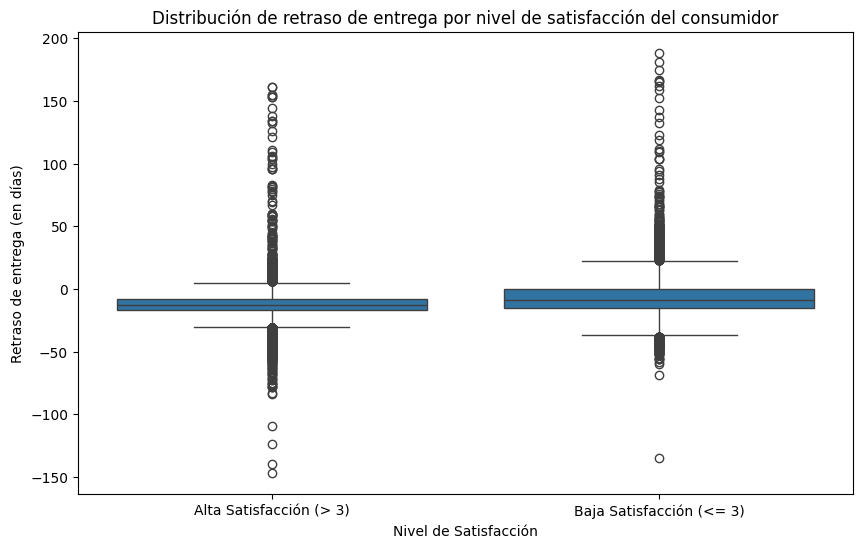

In [73]:
if 'review_score' in fact_orders.columns:
    fact_orders_for_hypothesis_3 = fact_orders.dropna(subset=['review_score']).copy()
    fact_orders_for_hypothesis_3['satisfaction_level'] = fact_orders_for_hypothesis_3['review_score'].apply(lambda score: 'Baja Satisfacción (<= 3)' if score <= 3 else 'Alta Satisfacción (> 3)')

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=fact_orders_for_hypothesis_3, x='satisfaction_level', y='delivery_delay')
    plt.title('Distribución de retraso de entrega por nivel de satisfacción del consumidor')
    plt.xlabel('Nivel de Satisfacción')
    plt.ylabel('Retraso de entrega (en días)')
    plt.show()


else:
    print("No se puede usar la columna.")

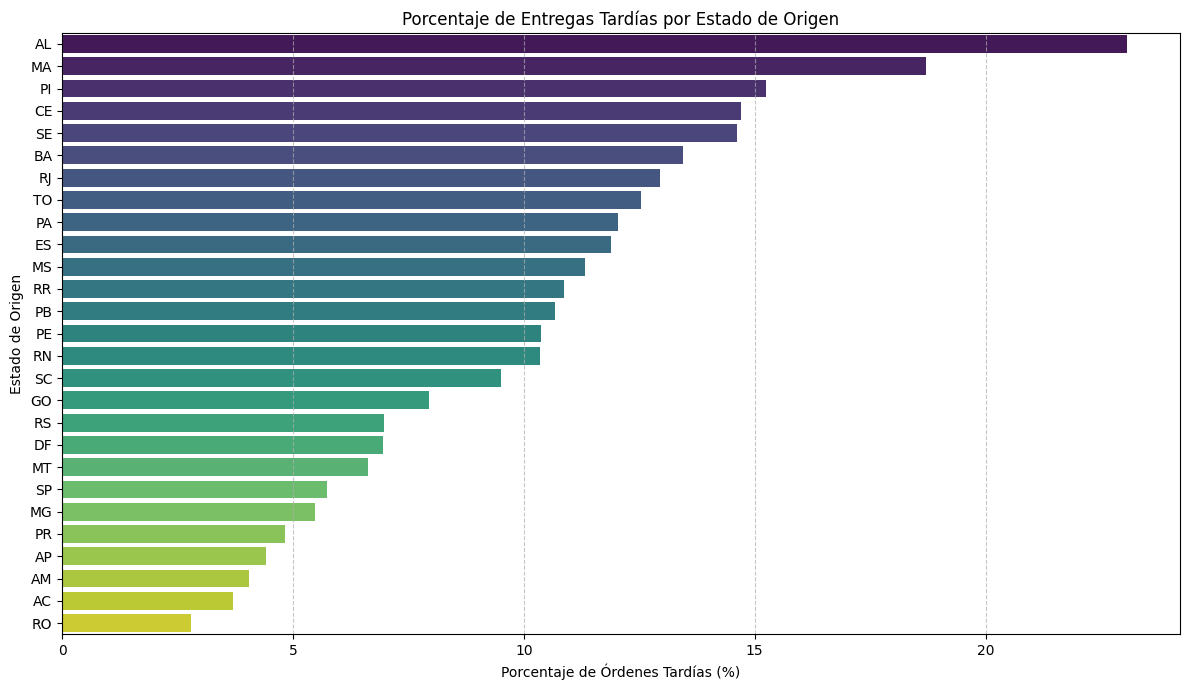

In [74]:
late_deliveries_by_state = fact_orders.groupby('customer_geo_state')['is_late'].mean().reset_index()

# Convertimos la proporción a porcentaje para mejor visualización
late_deliveries_by_state['percentage_late'] = late_deliveries_by_state['is_late'] * 100

# Ordenamos los estados por el porcentaje de entregas tardías de forma descendente
late_deliveries_by_state = late_deliveries_by_state.sort_values(by='percentage_late', ascending=False)

# Creamos el gráfico de barras
plt.figure(figsize=(12, 7)) # Definimos el tamaño del gráfico
sns.barplot(x='percentage_late', y='customer_geo_state', data=late_deliveries_by_state, palette='viridis')

plt.title('Porcentaje de Entregas Tardías por Estado de Origen') # Título del gráfico
plt.xlabel('Porcentaje de Órdenes Tardías (%)') # Etiqueta del eje X
plt.ylabel('Estado de Origen') # Etiqueta del eje Y
plt.grid(axis='x', linestyle='--', alpha=0.7) # Agregamos una cuadrícula en el eje X para mejor lectura
plt.tight_layout() # Ajusta el diseño para evitar que las etiquetas se corten
plt.show()

#Preprocesamiento para Machine Learning


## Correlación

,customer_zip_code_prefix,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay
customer_zip_code_prefix,1.000000,0.125477,-0.304201,0.057795,0.055175,-0.015816,0.282872,0.024429,-0.072757
customer_lat,0.125477,1.000000,0.450095,0.069126,0.063706,-0.042001,0.265111,0.055468,-0.011332
customer_lng,-0.304201,0.450095,1.000000,0.019477,0.040252,-0.052258,0.120331,0.072228,0.050850
payment_value_total,0.057795,0.069126,0.019477,1.000000,0.319081,-0.048911,0.071603,0.015457,-0.017714
payment_installments_max,0.055175,0.063706,0.040252,0.319081,1.000000,-0.031036,0.052885,0.008576,-0.030908
review_score,-0.015816,-0.042001,-0.052258,-0.048911,-0.031036,1.000000,-0.357467,-0.330312,-0.270454
delivery_days,0.282872,0.265111,0.120331,0.071603,0.052885,-0.357467,1.000000,0.587799,0.535873
is_late,0.024429,0.055468,0.072228,0.015457,0.008576,-0.330312,0.587799,1.000000,0.605266
delivery_delay,-0.072757,-0.011332,0.050850,-0.017714,-0.030908,-0.270454,0.535873,0.605266,1.000000


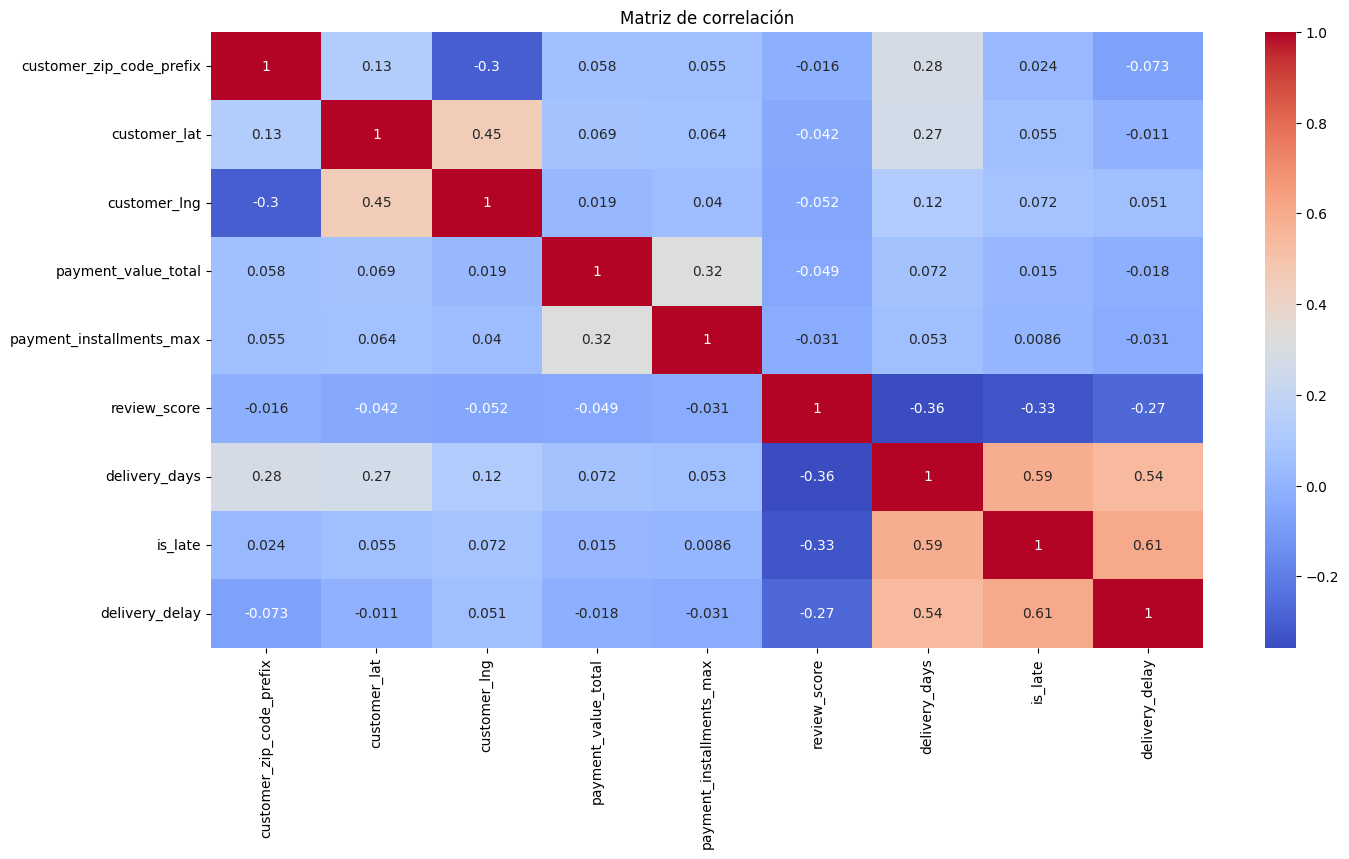

In [75]:
cols_to_exclude = ['z_score_payment_value_total_yeojohnson', 'z_score_payment_value_total',
                   'payment_value_total_orig', 'z_score_delivery_days_yeojohnson',
                   'z_score_delivery_days', 'delivery_days_orig', 'yeojohnson_payment_value_total',
                   'yeojohnson_delivery_days']

fact_orders_filtered = fact_orders.drop(columns=cols_to_exclude, errors='ignore')

# calcular correlaciones
corr = fact_orders_filtered.corr(numeric_only=True)
display(corr)

plt.figure(figsize=(16, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matriz de correlación")
plt.show()

No hay variables altamente correlacionadas es por eso que decidimos mantener todas.

## Encoding de variables categóricas


In [76]:
categorical_cols = fact_orders.select_dtypes(include=['object', 'category']).columns.tolist()
print("Variables categoricas en fact_orders:")
print(categorical_cols)

Variables categoricas en fact_orders:
['order_id', 'customer_id', 'order_status', 'customer_unique_id', 'customer_city', 'customer_state', 'customer_geo_city', 'customer_geo_state', 'payment_type_mode']


In [77]:
fact_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

In [78]:
fact_orders['customer_city'].nunique()

4119

In [79]:
fact_orders['customer_geo_city'].nunique()

4055

In [80]:
fact_orders['customer_geo_state'].nunique()

27

In [81]:
fact_orders['payment_type_mode'].nunique()

5

In [82]:
fact_orders['payment_type_mode'].unique()

array(['voucher', 'boleto', 'credit_card', 'debit_card', 'not_defined'],
      dtype=object)

De las variables categóricas vamos a analizar solamente las que tengan menos de 15 categorías. En este caso, serían 'order_status' y 'payment_type_mode'.

### One Hot Encoder

In [83]:
numerical_cols_for_modeling = fact_orders.select_dtypes(include=np.number).columns.tolist()
categorical_cols_for_modeling = ['payment_type_mode', 'order_status']

exclude_from_modeling = [
    'customer_zip_code_prefix',
    'yeojohnson_payment_value_total', 'z_score_payment_value_total_yeojohnson',
    'z_score_payment_value_total', 'payment_value_total_orig',
    'yeojohnson_delivery_days', 'z_score_delivery_days_yeojohnson',
    'z_score_delivery_days', 'delivery_days_orig'
]

numerical_cols_for_modeling = [col for col in numerical_cols_for_modeling if col not in exclude_from_modeling]

fact_orders_model = fact_orders[categorical_cols_for_modeling + numerical_cols_for_modeling].copy()

display(fact_orders_model.head())

,payment_type_mode,order_status,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay
0,voucher,delivered,-23.576983,-46.587161,38.71,1.0,4.0,8.0,0,-8.0
1,boleto,delivered,-12.177924,-44.660711,141.46,1.0,4.0,13.0,0,-6.0
2,credit_card,delivered,-16.745150,-48.514783,179.12,3.0,5.0,9.0,0,-18.0
3,credit_card,delivered,-5.774190,-35.271143,72.20,1.0,5.0,13.0,0,-13.0
4,credit_card,delivered,-23.676370,-46.514627,28.62,1.0,5.0,2.0,0,-10.0


In [84]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
onehot_encoded_cols = encoder.fit_transform(fact_orders_model[categorical_cols_for_modeling])

onehot_df = pd.DataFrame(onehot_encoded_cols, columns=encoder.get_feature_names_out(categorical_cols_for_modeling), index=fact_orders_model.index)

fact_orders_model_encoded = fact_orders_model.drop(columns=categorical_cols_for_modeling)
fact_orders_model_encoded = pd.concat([fact_orders_model_encoded, onehot_df], axis=1)

display(fact_orders_model_encoded.head())

,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_not_defined,payment_type_mode_voucher,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,-23.576983,-46.587161,38.71,1.0,4.0,8.0,0,-8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-12.177924,-44.660711,141.46,1.0,4.0,13.0,0,-6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,-16.745150,-48.514783,179.12,3.0,5.0,9.0,0,-18.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-5.774190,-35.271143,72.20,1.0,5.0,13.0,0,-13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-23.676370,-46.514627,28.62,1.0,5.0,2.0,0,-10.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Estandarización

In [85]:
numerical_cols_after_encoding = fact_orders_model_encoded.select_dtypes(include=np.number).columns.tolist()

scaler = StandardScaler()
scaled_numerical_data = scaler.fit_transform(fact_orders_model_encoded[numerical_cols_after_encoding])

scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_cols_after_encoding, index=fact_orders_model_encoded.index)

for col in numerical_cols_after_encoding:
    fact_orders_model_encoded[col] = scaled_numerical_df[col]

display(fact_orders_model_encoded.head())

,customer_lat,customer_lng,payment_value_total,payment_installments_max,review_score,delivery_days,is_late,delivery_delay,payment_type_mode_boleto,payment_type_mode_credit_card,payment_type_mode_debit_card,payment_type_mode_not_defined,payment_type_mode_voucher,order_status_approved,order_status_canceled,order_status_created,order_status_delivered,order_status_invoiced,order_status_processing,order_status_shipped,order_status_unavailable
0,-0.425976,-0.101629,-0.550961,-0.710885,-0.061056,-0.462136,-0.292292,0.380691,-0.498362,-1.807315,-0.124881,-0.005493,6.990716,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498
1,1.608561,0.373828,-0.088015,-0.710885,-0.061056,0.094311,-0.292292,0.577081,2.006573,-1.807315,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498
2,0.793389,-0.577375,0.081665,0.025585,0.681682,-0.350847,-0.292292,-0.601261,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498
3,2.751517,2.691219,-0.400070,-0.710885,0.681682,0.094311,-0.292292,-0.110285,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498
4,-0.443715,-0.083727,-0.596422,-0.710885,0.681682,-1.129873,-0.292292,0.184301,-0.498362,0.553307,-0.124881,-0.005493,-0.143047,-0.004485,-0.079529,-0.007091,0.175247,-0.056282,-0.055101,-0.106102,-0.078498


# RFM
**Recency**: tiempo desde la última compra. Se representa con la variable Recency (valores más bajos = más recientes).

**Frequency**: cantidad de compras realizadas.

**Monetary**: monto total gastado. Se obtiene como la suma de las columnas que representan gasto en distintas categorías.

In [87]:
# calcular RFM
reference_date = fact_orders['order_purchase_timestamp'].max() + pd.Timedelta(days=1)

customer_rfm = fact_orders.groupby('customer_id').agg(
    RFM_Recency=('order_purchase_timestamp', lambda date: (reference_date - date.max()).days),
    RFM_Frequency=('order_id', 'nunique'),
    RFM_Monetary=('payment_value_total', 'sum')
).reset_index()


# Monetary es 'RFM_Monetary'
# Frequency es 'RFM_Frequency'
# Recency es 'RFM_Recency'

display(customer_rfm[["RFM_Monetary", "RFM_Frequency", "RFM_Recency"]].describe().T)

if "RFM_Monetary" in customer_rfm.columns:
    p99_monetary = customer_rfm["RFM_Monetary"].quantile(0.99)
    ratio_outliers = (customer_rfm["RFM_Monetary"] > p99_monetary).mean() * 100
    print(f"Percentil 99 de 'RFM_Monetary': {p99_monetary:.2f}")
    print(f"Clientes por encima del p99: {ratio_outliers:.2f}%")

,count,mean,std,min,25%,50%,75%,max
RFM_Monetary,99441.0,160.994661,221.948922,9.59,62.01,105.29,176.97,13664.08
RFM_Frequency,99441.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00
RFM_Recency,99441.0,290.900192,153.667316,1.00,167.00,272.00,401.00,773.00


Percentil 99 de 'RFM_Monetary': 1075.79
Clientes por encima del p99: 1.00%


In [88]:
# Seleccionar las columnas RFM para el clustering
rfm_features = ['RFM_Recency', 'RFM_Frequency', 'RFM_Monetary']
X_rfm = customer_rfm[rfm_features]

# Escalar los datos RFM
scaler_rfm = StandardScaler()
X_rfm_scaled = scaler_rfm.fit_transform(X_rfm)

# Convertir el array escalado de nuevo a un DataFrame para facilitar la visualización y análisis
X_rfm_scaled_df = pd.DataFrame(X_rfm_scaled, columns=rfm_features, index=customer_rfm.index)

print("RFM data scaled successfully.")
display(X_rfm_scaled_df.head())

RFM data scaled successfully.


,RFM_Recency,RFM_Frequency,RFM_Monetary
0,0.306507,0.0,-0.208403
1,1.093926,0.0,-0.421652
2,1.991974,0.0,0.155106
3,0.892190,0.0,0.082701
4,-0.598049,0.0,-0.243231


## PCA en las columnas de RFM

Resultados PCA para RFM:
Componente 1: 50.05% de varianza explicada
Componente 2: 49.95% de varianza explicada
Componente 3: 0.00% de varianza explicada
Varianza total explicada por los 2 primeros componentes: 100.00%


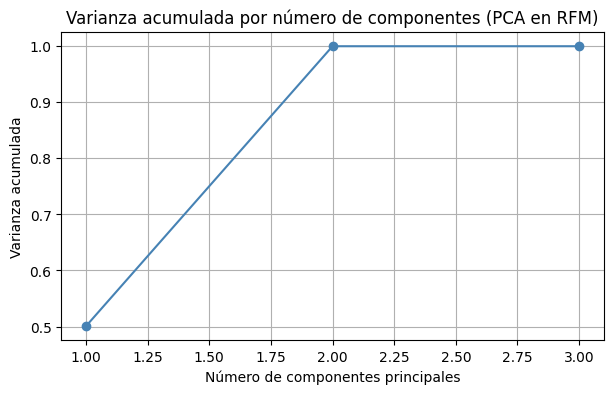

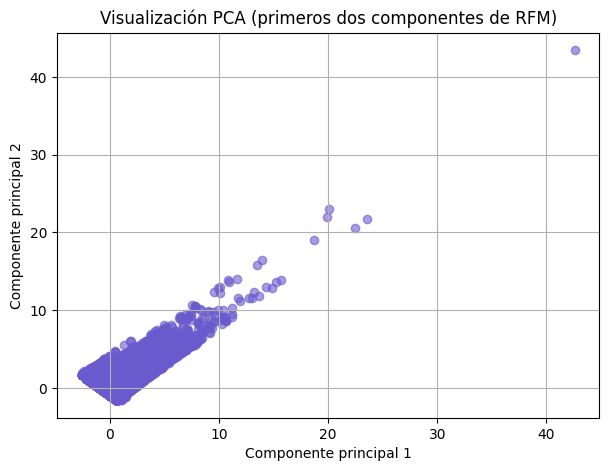

In [89]:
# Usamos las variables RFM escaladas directamente
# X_rfm_scaled_df ya es un DataFrame con las columnas correctas y escaladas

# Aplicamos PCA
# n_components debe ser igual o menor al número de características (3 para RFM)
pca_rfm = PCA(n_components=3)
pca_result_rfm = pca_rfm.fit_transform(X_rfm_scaled_df)

# Varianza explicada
explained_variance_rfm = pca_rfm.explained_variance_ratio_
cumulative_variance_rfm = np.cumsum(explained_variance_rfm)

# Mostramos resultados
print("Resultados PCA para RFM:")
for i, v in enumerate(explained_variance_rfm):
    print(f"Componente {i+1}: {v*100:.2f}% de varianza explicada")
print(f"Varianza total explicada por los 2 primeros componentes: {cumulative_variance_rfm[1]*100:.2f}%")

# Gráfico de varianza acumulada
plt.figure(figsize=(7,4))
plt.plot(range(1, len(cumulative_variance_rfm)+1), cumulative_variance_rfm, marker='o', color='steelblue')
plt.title("Varianza acumulada por número de componentes (PCA en RFM)")
plt.xlabel("Número de componentes principales")
plt.ylabel("Varianza acumulada")
plt.grid(True)
plt.show()

# Gráfico de dispersión (2 componentes principales)
plt.figure(figsize=(7,5))
plt.scatter(pca_result_rfm[:, 0], pca_result_rfm[:, 1], alpha=0.6, color='slateblue')
plt.title("Visualización PCA (primeros dos componentes de RFM)")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.grid(True)
plt.show()

In [ ]:
silhouette_scores_rfm = []
vrc_scores_rfm = []
k_range_metrics = range(2, 11) # Se necesita al menos 2 clusters para estas métricas

for k in k_range_metrics:
    kmeans_rfm = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels_rfm = kmeans_rfm.fit_predict(pca_result_rfm)

    # Calcular Silhouette Score
    score_silhouette = silhouette_score(pca_result_rfm, labels_rfm)
    silhouette_scores_rfm.append(score_silhouette)

    # Calcular Calinski-Harabasz Score (VRC)
    score_vrc = calinski_harabasz_score(pca_result_rfm, labels_rfm)
    vrc_scores_rfm.append(score_vrc)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range_metrics, silhouette_scores_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score para k óptimo en RFM (usando PCA)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(k_range_metrics, vrc_scores_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('VRC (Calinski-Harabasz Score)')
plt.title('VRC para k óptimo en RFM (usando PCA)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Encontrar el k óptimo basado en Silhouette y VRC
optimal_k_silhouette_rfm = k_range_metrics[np.argmax(silhouette_scores_rfm)]
max_silhouette_score_rfm = np.max(silhouette_scores_rfm)

optimal_k_vrc_rfm = k_range_metrics[np.argmax(vrc_scores_rfm)]
max_vrc_score_rfm = np.max(vrc_scores_rfm)

print(f"El valor máximo del coeficiente de silueta para RFM es {max_silhouette_score_rfm:.2f} en {optimal_k_silhouette_rfm} clusters.")
print(f"El pico del índice VRC para RFM se encuentra en {optimal_k_vrc_rfm} clusters, con un valor de {max_vrc_score_rfm:.2f}.")

KeyboardInterrupt: 

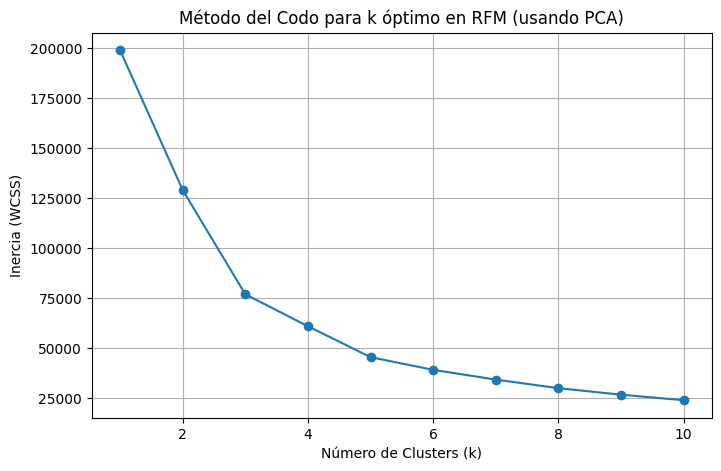

Observa el gráfico para identificar el 'codo' que sugiere el número óptimo de clusters.


In [90]:
# El resultado del PCA en RFM ya está en 'pca_result_rfm'

# Método del Codo para determinar el número óptimo de clusters (k)
inertia_rfm = []
k_range_rfm = range(1, 11)


for k in k_range_rfm:
    kmeans_rfm = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans_rfm.fit(pca_result_rfm)
    inertia_rfm.append(kmeans_rfm.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range_rfm, inertia_rfm, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para k óptimo en RFM (usando PCA)')
plt.grid(True)
plt.show()

print("Observa el gráfico para identificar el 'codo' que sugiere el número óptimo de clusters.")

## KMeans en RFM con 2 clusters

K-Means clustering aplicado con 2 clusters a los datos RFM (PCA-transformados).
Primeras filas del DataFrame de clientes con etiquetas de cluster:


,customer_id,RFM_Recency,RFM_Frequency,RFM_Monetary,RFM_Cluster
0,00012a2ce6f8dcda20d059ce98491703,338,1,114.74,0
1,000161a058600d5901f007fab4c27140,459,1,67.41,0
2,0001fd6190edaaf884bcaf3d49edf079,597,1,195.42,0
3,0002414f95344307404f0ace7a26f1d5,428,1,179.35,0
4,000379cdec625522490c315e70c7a9fb,199,1,107.01,1


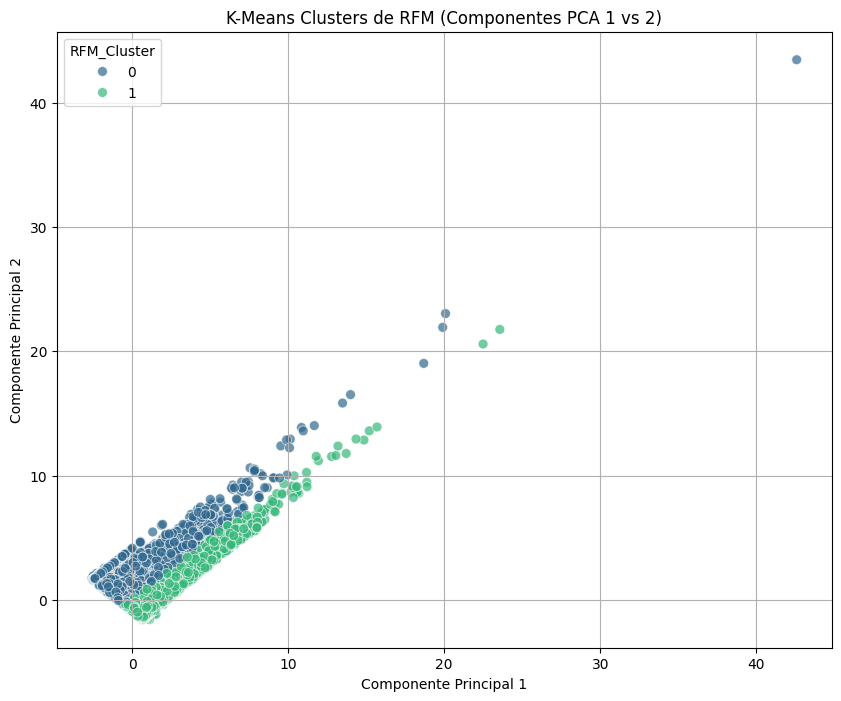

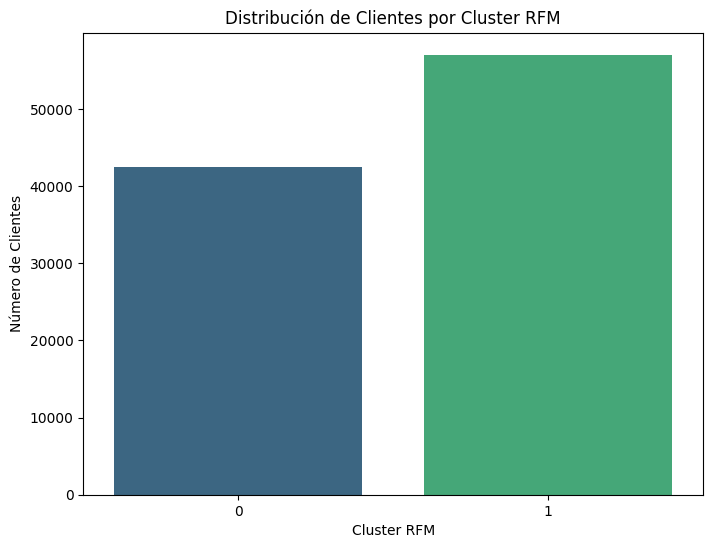

Características promedio de cada cluster RFM:


,RFM_Recency,RFM_Frequency,RFM_Monetary
RFM_Cluster,,,
0,440.304105,1.0,162.733294
1,179.785158,1.0,159.701601


Tamaño de cada cluster RFM:


,count
RFM_Cluster,
0,42413
1,57028


In [91]:
# Definir el número de clusters
num_clusters_rfm = 2

# Inicializar y ajustar el modelo K-Means
kmeans_rfm_final = KMeans(
    n_clusters=num_clusters_rfm,
    n_init=10,
    max_iter=300,
    random_state=42
)

kmeans_rfm_final.fit(pca_result_rfm)

# Asignar las etiquetas de cluster a los datos originales de customer_rfm
customer_rfm['RFM_Cluster'] = kmeans_rfm_final.labels_


print(f"K-Means clustering aplicado con {num_clusters_rfm} clusters a los datos RFM (PCA-transformados).")
print("Primeras filas del DataFrame de clientes con etiquetas de cluster:")
display(customer_rfm.head())

# Visualización de los clusters en los dos primeros componentes principales de PCA de RFM
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result_rfm[:, 0], y=pca_result_rfm[:, 1], hue=customer_rfm['RFM_Cluster'], palette='viridis', legend='full', s=50, alpha=0.7)
plt.title('K-Means Clusters de RFM (Componentes PCA 1 vs 2)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid(True)
plt.show()

# Visualización de la distribución de clientes por cluster
plt.figure(figsize=(8, 6))
sns.countplot(x='RFM_Cluster', data=customer_rfm, hue='RFM_Cluster', palette='viridis', legend=False)
plt.title('Distribución de Clientes por Cluster RFM')
plt.xlabel('Cluster RFM')
plt.ylabel('Número de Clientes')
plt.show()

# Analizar las características promedio de cada cluster
cluster_means = customer_rfm.groupby('RFM_Cluster')[['RFM_Recency', 'RFM_Frequency', 'RFM_Monetary']].mean()
print("Características promedio de cada cluster RFM:")
display(cluster_means)

cluster_sizes = customer_rfm['RFM_Cluster'].value_counts().sort_index()
print("Tamaño de cada cluster RFM:")
display(cluster_sizes)

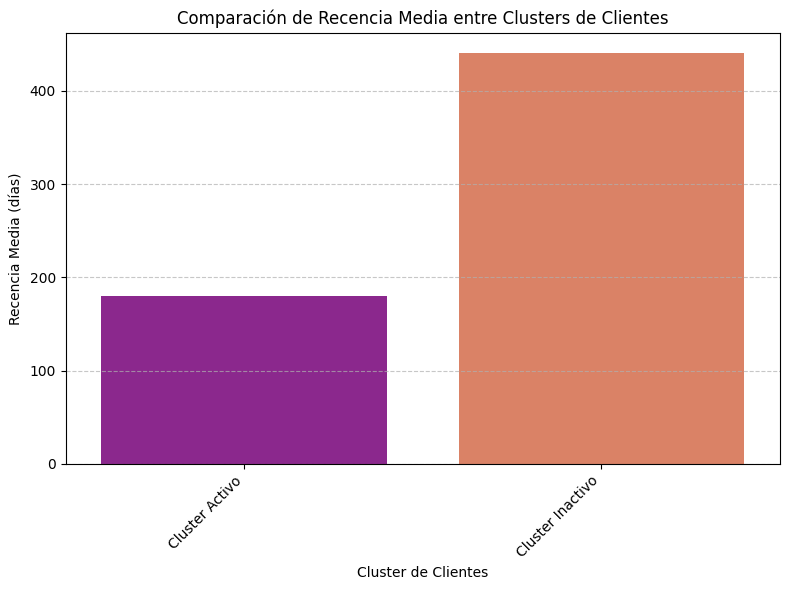

In [92]:
# Calcular la recencia media por cluster
recency_by_cluster = customer_rfm.groupby('RFM_Cluster')['RFM_Recency'].mean().reset_index()

# Identificar el cluster con menor recencia (más activo) y el con mayor recencia (más inactivo)
# Asumiendo que 0 es el cluster con menor recencia y 1 con mayor, según la interpretación previa de cluster_means
# Si esto no es consistente, se puede reasignar basado en los valores reales.
recency_by_cluster = recency_by_cluster.sort_values(by='RFM_Recency', ascending=True)
recency_by_cluster['Etiqueta_Cluster'] = ['Cluster Activo' if i == 0 else 'Cluster Inactivo' for i in range(len(recency_by_cluster))]

# Crear el gráfico de barras
plt.figure(figsize=(8, 6))
sns.barplot(x='Etiqueta_Cluster', y='RFM_Recency', data=recency_by_cluster, palette='plasma')
plt.title('Comparación de Recencia Media entre Clusters de Clientes')
plt.xlabel('Cluster de Clientes')
plt.ylabel('Recencia Media (días)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Tests de hipótesis

## Hipótesis 1

In [93]:
vars_to_test = ["RFM_Recency", "RFM_Frequency", "RFM_Monetary"]
cluster_col = "RFM_Cluster"
c0, c1 = 0, 1   # los dos clusters a comparar

def cohens_d(x, y):
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    vx, vy = np.var(x, ddof=1), np.var(y, ddof=1)
    if nx < 2 or ny < 2: return np.nan
    sp2 = ((nx-1)*vx + (ny-1)*vy) / (nx+ny-2)
    return (np.mean(x) - np.mean(y)) / np.sqrt(sp2) if sp2 > 0 else np.nan

def cliffs_delta(x, y):
    # |delta| interpreta magnitud: 0.147 (pequeño), 0.33 (mediano), 0.474 (grande)
    x = np.asarray(x); y = np.asarray(y)
    nx, ny = len(x), len(y)
    if nx == 0 or ny == 0: return np.nan
    # más eficiente que doble bucle para muestras grandes: usar ranking
    ranks = stats.rankdata(np.concatenate([x, y]))
    rx = ranks[:nx].sum()
    # delta = (2*rx - nx*(nx+1)) / (nx*ny) - 1  -> corrección:
    delta = (2*rx - nx*(nx+1)) / (nx*ny) - 1
    return delta

print("Tamaño de cada cluster:")
print(customer_rfm.groupby(cluster_col).size())

results = []
for v in vars_to_test:
    print("\n" + "="*70)
    print(f"Variable: {v}")

    x = customer_rfm.loc[customer_rfm[cluster_col] == c0, v].dropna()
    y = customer_rfm.loc[customer_rfm[cluster_col] == c1, v].dropna()

    # Chequeo: si la varianza es 0 en alguno → no se puede comparar con t ni MWU
    if x.nunique() <= 1 or y.nunique() <= 1:
        print("⚠️ Alguno de los grupos es constante → no se puede testear diferencia (varianza=0).")
        print(f"Medias: C{c0}={x.mean():.4f}, C{c1}={y.mean():.4f}")
        results.append([v, "Constante", np.nan, np.nan, np.nan, np.nan, np.nan])
        continue

    # 1) Normalidad
    p_norm_x = stats.normaltest(x).pvalue if len(x) >= 8 else np.nan
    p_norm_y = stats.normaltest(y).pvalue if len(y) >= 8 else np.nan
    print(f"Normalidad (D’Agostino–Pearson): p_C{c0}={p_norm_x:.3g}, p_C{c1}={p_norm_y:.3g}")


    # 2) Homogeneidad de varianzas (Levene)
    p_levene = stats.levene(x, y, center='median').pvalue
    print(f"Levene (varianzas iguales): p={p_levene:.3g}")

    # 3) Elegir test
    normal_ok = (p_norm_x is not np.nan and p_norm_x >= 0.05) and (p_norm_y is not np.nan and p_norm_y >= 0.05)

    if normal_ok:
        # t-test Welch por defecto (robusto si varianzas difieren)
        tstat, p_t = stats.ttest_ind(x, y, equal_var=False)
        d = cohens_d(x, y)
        print(f"t de Student (Welch): t={tstat:.3f}, p={p_t:.3g}, Cohen's d={d:.3f}")
        test_used = "t-Welch"
        stat, pval, eff, eff_name = tstat, p_t, d, "Cohen's d"
    else:
        # No normalidad → Mann–Whitney U
        u, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
        delta = cliffs_delta(x, y)
        print(f"Mann–Whitney U: U={u:.0f}, p={p_u:.3g}, Cliff's δ={delta:.3f}")
        test_used = "Mann–Whitney"
        stat, pval, eff, eff_name = u, p_u, delta, "Cliff's δ"

    # 4) Resumen
    print(f"Medias: C{c0}={x.mean():.3f}, C{c1}={y.mean():.3f} | Medianas: C{c0}={x.median():.3f}, C{c1}={y.median():.3f}")
    results.append([v, test_used, stat, pval, eff_name, eff, p_levene])

cols = ["Variable", "Test", "Estadístico", "p-valor", "Efecto", "Magnitud", "p-Levene"]
res_df = pd.DataFrame(results, columns=cols).sort_values("p-valor")
print("\nResumen comparaciones 0 vs 1:")
print(res_df.to_string(index=False))

Tamaño de cada cluster:
RFM_Cluster
0    42413
1    57028
dtype: int64

Variable: RFM_Recency
Normalidad (D’Agostino–Pearson): p_C0=0, p_C1=0
Levene (varianzas iguales): p=0
Mann–Whitney U: U=2418689529, p=0, Cliff's δ=1.000
Medias: C0=440.304, C1=179.785 | Medianas: C0=427.000, C1=182.000

Variable: RFM_Frequency
⚠️ Alguno de los grupos es constante → no se puede testear diferencia (varianza=0).
Medias: C0=1.0000, C1=1.0000

Variable: RFM_Monetary
Normalidad (D’Agostino–Pearson): p_C0=0, p_C1=0
Levene (varianzas iguales): p=0.00442
Mann–Whitney U: U=1201523308, p=0.0799, Cliff's δ=-0.006
Medias: C0=162.733, C1=159.702 | Medianas: C0=104.020, C1=106.530

Resumen comparaciones 0 vs 1:
     Variable         Test  Estadístico  p-valor    Efecto  Magnitud  p-Levene
  RFM_Recency Mann–Whitney 2418689529.0 0.000000 Cliff's δ  0.999968  0.000000
 RFM_Monetary Mann–Whitney 1201523307.5 0.079879 Cliff's δ -0.006484  0.004425
RFM_Frequency    Constante          NaN      NaN       NaN       NaN  

## Hipótesis 3

In [ ]:
fact_orders.columns

In [94]:
# 0) Filtro y preparación
df = fact_orders.copy()

# Mantener filas válidas para ambos campos
df = df[['review_score', 'delivery_days']].dropna()

# Review binario para grupos (≤3 vs >3)
df['review_le3'] = (df['review_score'] <= 3).astype(int)

# Grupos
x = df.loc[df['review_le3'] == 1, 'delivery_days']  # grupo reviews ≤ 3
y = df.loc[df['review_le3'] == 0, 'delivery_days']  # grupo reviews > 3

print(f"N (≤3): {len(x)}, N (>3): {len(y)}")

# 1) Normalidad por grupo (D’Agostino–Pearson) — informativo
p_norm_x = stats.normaltest(x).pvalue if len(x) >= 8 else np.nan
p_norm_y = stats.normaltest(y).pvalue if len(y) >= 8 else np.nan
print(f"Normalidad (D’Agostino–Pearson) p (≤3)={p_norm_x:.3g}, p (>3)={p_norm_y:.3g}")


# 2) Test principal: t-Welch si ambas normales; si no, Mann–Whitney U (+ KS 2-samples)
normal_ok = (not np.isnan(p_norm_x) and p_norm_x >= 0.05) and \
            (not np.isnan(p_norm_y) and p_norm_y >= 0.05)

if normal_ok:
    # t de Student con corrección de Welch (varianzas desiguales por defecto)
    tstat, p_t = stats.ttest_ind(x, y, equal_var=False)
    print(f"t de Student (Welch): t={tstat:.3f}, p={p_t:.3g}")
else:
    # Mann–Whitney U (no paramétrico)
    u, p_u = stats.mannwhitneyu(x, y, alternative="two-sided")
    print(f"Mann–Whitney U: U={u:.0f}, p={p_u:.3g}")
    # Comparación de distribuciones completa (opcional, visto en clase)
    ks = stats.ks_2samp(x, y)
    print(f"Kolmogorov–Smirnov 2-muestras: D={ks.statistic:.3f}, p={ks.pvalue:.3g}")


# 3) Resumen de tendencia central (para el reporte)
print(f"Medianas delivery_days:  ≤3 = {x.median():.3f}  |  >3 = {y.median():.3f}")
print(f"Medias delivery_days:    ≤3 = {x.mean():.3f}    |  >3 = {y.mean():.3f}")


# 4) Enfoque B: Asociación monotónica (Spearman) entre demora y rating (1–5)
rho, p_s = stats.spearmanr(df['delivery_days'], df['review_score'])
print(f"Spearman: ρ={rho:.3f}, p={p_s:.3g}")
# Interpretación esperada: ρ < 0 y p pequeño (más días ⇒ peores ratings ⇒ review_score baja)

N (≤3): 22857, N (>3): 76584
Normalidad (D’Agostino–Pearson) p (≤3)=0, p (>3)=0
Mann–Whitney U: U=1171993671, p=0
Kolmogorov–Smirnov 2-muestras: D=0.255, p=0
Medianas delivery_days:  ≤3 = 14.000  |  >3 = 9.000
Medias delivery_days:    ≤3 = 17.385    |  >3 = 10.591
Spearman: ρ=-0.259, p=0


# Proyecto a producción

# Tipo de despliegue

* **Batch diario + eventos puntuales.**

  * **Segmentación RFM / clustering:** no requiere respuesta en milisegundos, se recalcula **1 vez al día** (o **semanal** si se busca estabilidad).
  * **Alertas operativas sobre logística/satisfacción** (H3: *más demora ⇒ peor review*): conviene **evento casi en tiempo real** (p. ej., cuando un pedido supera cierto umbral de `delivery_days` previsto) para disparar **acciones proactivas** (contacto al cliente, upgrade de envío).
* **Embebido en sistemas existentes.**

  * Los **scores RFM / etiquetas de cluster** se exponen por **API interna** para que el CRM, el motor de campañas y el helpdesk los consuman.
  * El **tablero** (tipo BI) se refresca programado y se integra en el portal analítico de la empresa.

# Actualización del tablero / modelo

* **Ingesta incremental diaria** de órdenes, ítems, pagos y reviews (lo replicamos con nuestras dos fact tables para evitar duplicados).
* **Cálculo RFM** y métricas de operación **diario**; **tablero** refresco **diario** (cada mañana) y **on-demand** para picos (hot sale).
* **Automatización:** **Airflow** (o **cron**/Cloud Scheduler) para:

  1. extraer → 2) transformar (joins “orders”/“items”, agregación de pagos, compactación geográfica por prefijo) → 3) cargar a DW → 4) recalcular RFM/labels → 5) refrescar dashboard.

# Infraestructura general

* **Cloud + serverless/containers.**

  * **Data Lake** (S3/GCS) en **Parquet**; **DW** (BigQuery/Redshift/Snowflake) para el modelo analítico (dos facts como en el proyecto).
  * **Pipelines** en **Airflow**; **APIs** para exponer RFM/segmento vía **Cloud Run/Lambda** (contenedores livianos).
* **Bases de soporte:**

  * **Tabla de scores/etiquetas** (RFM, cluster, fecha de cálculo) para auditoría/histórico.
  * **Logs** de inferencia (quién consultó, qué score devolvimos) y **bitácora de datos** (conteos, nulos, rangos).

# Mantenimiento y monitoreo

* **Responsables:** equipo de **Datos** (pipeline + calidad) y equipo de **CRM/Marketing** (uso de segmentos y campañas).
* **Qué monitorear (observabilidad)**

  * **Calidad de datos** (volúmenes, % nulos, rangos, duplicados por clave) — si se rompe la ingesta, que el tablero **no** publique.
  * **Drift de variables clave:**

    * **RFM/Recency** (nuestro principal separador en clusters). Si la distribución se desplaza, revisar cortes y reglas de campañas.
    * **Logística y satisfacción**: *delivery_days*, *review_score* (de H3). Si suben los días o bajan los puntajes, alertar.
  * **Métricas de negocio accionables:**

    * **Tasa de recompra** por cluster;
    * **% cancelación** por tercil de **% flete** (H4 mostró asociación, aunque no lineal);
    * **Satisfacción promedio** por tercil de **% flete** (efecto pequeño pero consistente).
* **Cuándo re-entrenar/ajustar:**

  * **RFM/clusters**: **trimestral** o **antes** si hay **drift** sostenido (> X% de cambio en medianas/percentiles de recency o si los clusters se desbalancean).
  * **Reglas de negocio**: si cambian políticas de envío/precios o estacionalidad (ej. fiesta/frete).
* **Alarmas:** umbrales simples (p. ej., `P90(delivery_days)` > objetivo, `review_score` medio < 4.0, `% cancelación` > X%) con aviso a Slack/Email.